# Information Retrieval project

**Authors:** M. Fabiani, T. Falaschi, A. Franchini, R.A. Sacco

## Table of contents

- [1. Set up environment and dependencies](##1-set-up-environment-and-dependencies)
- [2. Loading the Dataset](##2-loading-the-dataset)
- [3. Text Preprocessing](##3-text-preprocessing)
- [4. Building the inverted index](##4-building-the-inverted-index)
- [5. Index compression](##5-index-compression)
- [6. Creation of posting list](##6-creation-of-posting-list)
- [7. Query processing](##7-query-processing)
- [8. BM25 vs TFIDF](##8-bm25-vs-tfidf)
- [9. DAAT vs DAAT Improved](##9-daat-vs-daat-improved)
- [10. TAAT vs TAAT Improved](##10-taat-vs-taat-improved)
- [11. Query Expansion on TAAT and DAAT](##11-query-expansion-on-taat-and-daat)
- [12. Comparison with PyTerrier BM25 baseline](##12-comparison-with-pyterrier-bm25-baseline)


## 1. Set up environment and dependencies

In [ ]:
!pip install ir_datasets
!pip install python-terrier
!pip install PyStemmer
!pip install humanize

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.1/866.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.0/149.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.8 MB/s eta 0:00:00
  Created wheel for warc3-wet-clueweb09: filename=warc3_wet_clueweb09-0.2.5-py3-none-any.whl size=18919 sha256=b9c7e0041d18ce46c3b4ae35477b7bceec9e0bb7786875352547a6a06fbbc5b0
  Stored in directory: /root/.cache/pip/wheels/f6/85/c2/9f0f621def52a1d5db7d29984f81e45f9fb6dfeb1a4eb6e31c
  Created wheel for cbor: filename=cbor-1.0.0-cp312-cp312-linux_x86_64.whl size=55023 sha256=c794bebe02d11cdc5c0f53d8dd2337607a2003a4d9e06868cf07b4e9ee31778c
  Stored in directory: /root/.cache/pip/wheels/44/3e/21/a739cbcc331a1ab45c326d6edbdac

In [ ]:
import time
import ir_datasets
import re
import string
import nltk
import Stemmer
import os
import pickle
import gzip
from collections import Counter, defaultdict
from tqdm.auto import tqdm
import numpy as np
from array import array
import humanize
import shutil
import math
import heapq
import random
from ir_measures import *
import pyterrier as pt
from pyterrier.measures import *
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import itertools

In [ ]:
if not pt.started():
    pt.init()

/tmp/ipython-input-3057724015.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():


terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...


https://repo1.maven.org/maven2/org/terrier/terrier-assemblies/5.11/terrier-assemblies-5.11-jar-with-dependenci…

Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...


https://repo1.maven.org/maven2/org/terrier/terrier-python-helper/0.0.8/terrier-python-helper-0.0.8.jar:   0%| …

Done


Java started and loaded: pyterrier.java.colab, pyterrier.java, pyterrier.java.24, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
/tmp/ipython-input-3057724015.py:2: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()


In [ ]:
def profile(f):
    def f_timer(*args, **kwargs):
        start = time.time()
        result = f(*args, **kwargs)
        end = time.time()
        ms = (end - start) * 1000
        print(f"{f.__name__} ({ms:.3f} ms)")
        return result
    return f_timer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_PATH = "/content/drive/Shareddrives/MIRCV Project/IR"
TEST_QE = True # Set this variable to run the query expansion cells

## 2. Loading the Dataset

We utilized the MS MARCO Passage dataset, a standard benchmark in Information Retrieval. Specifically, the dataset consists of 8.8 million documents and 200 queries.

In [ ]:
collection = ir_datasets.load("msmarco-passage/trec-dl-2020")
docs = collection.docs_iter()
ndocs = collection.docs_count()

## 3.  Text Preprocessing

In this section, we implement a *preprocessing pipeline* to standardize both documents and queries, ensuring they share a compatible vocabulary. The process involves several normalization steps:

1. Lowercasing
2. Ampersand (`&`) conversion to `and `
3. Translation of special chars into a normalized form
4. Acronyms management with a regex
5. Punctuation removal and substitution with whitespaces
6. Whitespaces stripping & reduction
7. Tokenization
8. Stopwords removal


Finally, we apply *stemming* to reduce terms to their root form and improve term matching during retrieval. For this task, we
chose **PyStemmer** instead of the standard NLTK PorterStemmer. Although NLTK is widely adopted in NLP research, its stemming implementation is written in pure Python, which can introduce a non-negligible computational overhead when processing large-scale collections.

PyStemmer, on the other hand, is a Python wrapper around the highly optimized C implementation of the Snowball stemming algorithm. This results in substantially faster execution, enabling text processing at a scale that would be impractical with a pure Python stemmer. Given the size of the MS MARCO corpus and the need to efficiently preprocess millions of documents during indexing, PyStemmer provides a more suitable trade-off between linguistic accuracy and computational efficiency.

In [ ]:
nltk.download('stopwords')

# Translation table for normalizing curly quotes, apostrophes, and dashes
CHAR_TRANSLATION = str.maketrans("‘’´“”–-", "'''\"\"--")
# Punctuation translation: replace all punctuation marks with spaces
PUNCT_TRANSLATION = str.maketrans(string.punctuation, " " * len(string.punctuation))
# English stopword list
STOPWORDS = set(nltk.corpus.stopwords.words('english'))
# Stemmer
STEM = Stemmer.Stemmer('english')

def preprocess(text):
    """
    Clean and normalize a text string for Information Retrieval tasks.
    Steps:
      1. Lowercase all characters
      2. Replace ampersands (&) with 'and'
      3. Normalize Unicode punctuation (quotes, dashes)
      4. Remove dots in acronyms (e.g., 'U.S.A.' → 'USA') but keep decimals
      5. Remove punctuation and collapse multiple spaces
      6. Tokenize text into words
      7. Remove stopwords
      8. Apply stemming
    Returns:
      A list of processed tokens.
    """

    #basic normalization
    text = text.lower().replace("&", " and ").translate(CHAR_TRANSLATION)

    #remove dots from acronyms (but keep decimal numbers)
    text = re.sub(r"\.(?!(\S[^. ])|\d)", "", text)

    #remove punctuation and collapse whitespace
    text = text.translate(PUNCT_TRANSLATION)
    text = re.sub(r"\s+", " ", text).strip()

    #tokenize
    tokens = text.split()
    #remove stopwords
    tokens = [t for t in tokens if t not in STOPWORDS]
    #stemming
    tokens = STEM.stemWords(tokens)
    return tokens


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 4. Building the inverted index

The `build_index` function is responsible for constructing the core data structures of the Information Retrieval system by performing a single pass over the document collection. It generates the following components:

1.  **Lexicon (`lexicon`)**: A dictionary mapping each unique term to a list containing:
    * `term_id`: An internal integer ID assigned sequentially to new terms.
    * `doc_freq`: The number of documents containing the term (Document Frequency).
    * `coll_freq`: The total number of occurrences of the term across the entire collection (Collection Frequency).

2.  **Inverted Index (`inv_d`, `inv_f`)**: To optimize memory usage and access time, the posting lists are split into two parallel dictionaries keyed by `term_id`:
    * `docids`: Stores the list of document IDs where the term appears.
    * `freqs`: Stores the corresponding term frequencies (TF) for each document.

3.  **Document Index (`doc_index`)**: A forward index implemented as a list, where the index position corresponds to the internal integer `doc_id`. Each entry stores the original string identifier of the document and its length (number of tokens), which are essential for normalization during retrieval (e.g., BM25).

The function utilizes the `preprocess` pipeline defined earlier to tokenize and normalize text before computing term statistics using a `Counter`. Finally, it returns the constructed indexes along with global collection statistics.

In [ ]:
@profile
def build_index(docs, ndocs=None):
    """
        the lexicon will be in the form:
        {term: [termid, doc_freq, coll_freq], ...}
    """
    lexicon = {}
    """
        the document index will be in the form:
        [(docno, doclen), (docno, doclen), ...]
        ordered by docid
    """
    doc_index = []
    """
        the inverted index will be in the form:
        'docids' : {termid: [docid1, docid2, ...], ...}
        'freqs' : {termid: [tf1, tf2, ...], ...}
        separating two different arrays for docids and term frequencies
    """
    inv_d, inv_f = {}, {}
    termid = 0

    num_docs = 0
    total_dl = 0
    total_toks = 0
    for docid, doc in tqdm(enumerate(docs), desc='Indexing', total=ndocs):
        tokens = preprocess(doc.text)
        token_tf = Counter(tokens)
        for token, tf in token_tf.items():
            if token not in lexicon:
                lexicon[token] = [termid, 0, 0]
                inv_d[termid], inv_f[termid] =  [], []
                termid += 1
            token_id = lexicon[token][0]
            inv_d[token_id].append(docid)
            inv_f[token_id].append(tf)
            lexicon[token][1] += 1
            lexicon[token][2] += tf
        doclen = len(tokens)
        doc_index.append((str(doc.doc_id), doclen))
        total_dl += doclen
        num_docs += 1


    stats = {
        'num_docs': 1 + docid,
        'num_terms': len(lexicon),
        'num_tokens': total_dl,
    }
    return lexicon, {'docids': inv_d, 'freqs': inv_f}, doc_index, stats

### Build the reduced direct index

The direct index is created starting from the lexicon and inverted index obtained from the build_index functions it contains the top k terms for each document based on its tf

The ideal would be to get the direct index with the top k terms for document in RAM, to have faster acces to it and not slow down the query expansion process too much. However the basic colab doesn't provide enough memory to allocate both inverted index and the reduced direct index. For this reason the direct index will be kept in secondar memory and accessed when needed using the numpy memmap functionalities.

In [ ]:
"""
def build_direct_index_topk(lexicon, inv, stats, k_top=10):

    #Constructs a compact direct index:
     # direct_index[docid] = [(termid, tf), ...]   # containing at most k_top elements

    #Retains ONLY the top k_top terms per document, selected based on term frequency (tf).
    #Memory complexity: O(num_docs * k_top).

    num_docs = stats['num_docs']

    # For each document, initialize a small list to store (termid, tf) tuples
    direct_index = [[] for _ in range(num_docs)]

    # Track the current minimum tf in the top-k list for each document,
    # allowing for quick decisions on whether to replace an element or not.
    min_tf = [0] * num_docs

    for term, (termid, df, coll_freq) in tqdm(lexicon.items(), desc="Building direct top-k"):
        docids = inv['docids'][termid]
        freqs  = inv['freqs'][termid]

        for docid, tf in zip(docids, freqs):
            docid = int(docid)
            curr_list = direct_index[docid]

            # If we haven't reached k_top terms yet, append the current one
            if len(curr_list) < k_top:
                curr_list.append((termid, tf))
                # Update min_tf
                if len(curr_list) == 1 or tf < min_tf[docid]:
                    min_tf[docid] = tf
            else:
                # If the current tf is greater than the tracked minimum, replace the minimum element
                if tf <= min_tf[docid]:
                    continue

                # Find the index of the term with the minimum tf
                min_idx = min(range(k_top), key=lambda i: curr_list[i][1])
                curr_list[min_idx] = (termid, tf)

                # Recalculate the minimum in the updated list
                min_tf[docid] = min(x[1] for x in curr_list)

    return direct_index
"""

'\ndef build_direct_index_topk(lexicon, inv, stats, k_top=10):\n\n    #Constructs a compact direct index:\n     # direct_index[docid] = [(termid, tf), ...]   # containing at most k_top elements\n\n    #Retains ONLY the top k_top terms per document, selected based on term frequency (tf).\n    #Memory complexity: O(num_docs * k_top).\n\n    num_docs = stats[\'num_docs\']\n\n    # For each document, initialize a small list to store (termid, tf) tuples\n    direct_index = [[] for _ in range(num_docs)]\n\n    # Track the current minimum tf in the top-k list for each document,\n    # allowing for quick decisions on whether to replace an element or not.\n    min_tf = [0] * num_docs\n\n    for term, (termid, df, coll_freq) in tqdm(lexicon.items(), desc="Building direct top-k"):\n        docids = inv[\'docids\'][termid]\n        freqs  = inv[\'freqs\'][termid]\n\n        for docid, tf in zip(docids, freqs):\n            docid = int(docid)\n            curr_list = direct_index[docid]\n\n        

To perform **Pseudo Relevance Feedback (PRF)**, we would need to read the text of the *top documents* and count the most frequent terms. On MS MARCO (millions of documents) this is too expensive for Colab.

The practical idea we use is to build a **reduced direct index**: for each document we store only the **k most frequent terms** (termid, tf). This way, during Query Expansion we can fetch candidate terms quickly without opening the full document.

To stay within Colab RAM limits, the reduced direct index is stored on disk using **numpy.memmap**:
- shape = (num_docs, k_top, 2)
- [:, :, 0] = termid (=-1 for empty slots)
- [:, :, 1] = tf

This is a compromise: it is not the most sophisticated QE possible, but it is **reasonably accurate** and, most importantly, **feasible** on Colab without blowing up RAM and runtime.

In [ ]:
def build_direct_index_topk(lexicon, inv, stats, k_top=10, memmap_path="/content"):
    """
    Constructs a top-k direct index per document and saves it to disk via numpy.memmap.

    Structure:
      direct_mm[docid, j, 0] = termid
      direct_mm[docid, j, 1] = tf

    Initially, all cells are set to (termid=-1, tf=0).
    For each (termid, docid, tf) in the posting lists:
      - if there is a free slot in the document's top-k, use it.
      - otherwise, replace the entry having the minimum tf if the current tf is greater.

    Parameters:
      - lexicon: {term: [termid, doc_freq, coll_freq], ...}
      - inv: {'docids': {termid: [...]}, 'freqs': {termid: [...]}}
      - stats: dict containing at least 'num_docs'
      - k_top: number of top-k terms to keep per document
      - memmap_path: path to the memmap file to be created
    """
    num_docs = stats['num_docs']

    # create memmap storage for (termid, tf)
    direct_mm = np.memmap(
        memmap_path,
        dtype=np.int32,
        mode='w+',
        shape=(num_docs, k_top, 2)
    )

    # initialize all termids to -1 and tf to 0
    direct_mm[:, :, 0] = -1
    direct_mm[:, :, 1] = 0

    # for each term, update the top-k entries of the documents where it appears
    for term, (termid, df, coll_freq) in tqdm(lexicon.items(), desc="Building direct top-k memmap"):
        docids = inv['docids'][termid]
        freqs  = inv['freqs'][termid]

        for docid, tf in zip(docids, freqs):
            docid = int(docid)
            row = direct_mm[docid]  # shape (k_top, 2): [ [termid, tf], ... ]

            # 1) find a free slot (termid == -1)
            free_positions = np.where(row[:, 0] == -1)[0]
            if free_positions.size > 0:
                j = int(free_positions[0])
                row[j, 0] = termid
                row[j, 1] = tf
            else:
                # 2) no free slot: replace the minimum if current tf is greater
                # row[:, 1] refers to the tf column
                j_min = int(np.argmin(row[:, 1]))
                if tf > row[j_min, 1]:
                    row[j_min, 0] = termid
                    row[j_min, 1] = tf

    # ensure changes are written to disk
    direct_mm.flush()
    del direct_mm

Create an array to recover a term from its termid.

In our index we work with **termid** integers to be fast and compact. For Query Expansion, however, we must build an expanded text query, so we need to convert the selected termids back into **string terms**.

This function builds an array indexed by termid, so the conversion is O(1)

In [ ]:
def build_termid2term(lexicon):
    """
    Creates a termid -> term (string) mapping, useful for reconstructing expanded queries.
    """
    num_terms = max(info[0] for info in lexicon.values()) + 1
    termid2term = [None] * num_terms
    for term, (termid, df, coll_freq) in lexicon.items():
        termid2term[termid] = term
    return termid2term

## 5. Index compression


We implemented compression directly at the byte level to maximize efficiency, precision, and compatibility with real-world standards. By applying Variable-Byte Encoding (VBEncode), each integer is represented using the minimal number of bytes necessary, achieving a highly compact and performant encoding scheme.

This design offers major logistical benefits:

- It is compact, consuming minimal disk space.
- It is portable, making it easy to copy, transfer, or deploy to new environments.

#### Key features
Our compression pipeline is a two-stage process designed for both simplicity and efficiency:

1. **Gap Encoding:** First, the sorted list of docIDs for a term is converted into gaps (the differences between consecutive IDs). This transforms a list of large, increasing numbers into a list of mostly small integers.
2. **Variable-Byte (VB) Encoding:** Second, this VB encoding is applied to compress the small integer gaps.

A crucial part of our strategy is to also compress the term frequencies (TFs) using the same VB encoding. This choice provides two major advantages:

1. **Space Optimization:** Due to Zipf's Law, the vast majority of TFs are very small integers (overwhelmingly 1, 2, or 3). Storing them as fixed-width 16 or 32-bit integers would be extremely wasteful. VB encoding is perfectly suited for this data, compressing most TFs into a single byte.

2. **Decoder Efficiency:** Compressing both allows us to create a uniform, interleaved data stream ([gap1, tf1, gap2, tf2, ...]). This design is highly efficient:

    - **Simple Code:** We only need a single, simple VB decoder that reads both values simultaneously in a tight loop.
    - **CPU Cache Locality:** This stream design significantly boosts decompression speed. A gap and its corresponding TF are physically adjacent,  meaning the CPU finds both pieces of data in its cache, avoiding a slower lookup to another memory location.

In [ ]:
# Variable-Byte encode/decode
def VBEncode(n):
    """Encode a single non-negative integer into VB code (list of bytes)."""
    if n < 0:
        raise ValueError("VBEncode expects non-negative integers")
    byte = []
    while True:
        byte.append(n % 128)  # 7 LSB kept, MSB=0 for continuation
        if n < 128:
            break
        n //= 128
    byte[0] += 128  # set MSB=1 on the last byte (end marker)
    return byte[::-1]

def VBEncodeList(n_list):
    """Encode a list of non-negative integers with VB code (concatenated)."""
    out = []
    for n in n_list:
        out.extend(VBEncode(n))
    return out

def VBDecode(stream):
    """Decode a VB-encoded byte stream back to list of integers (utility/testing)."""
    n_list, n = [], 0
    for b in stream:
        if b >= 128:          # MSB=1 → this is the last byte of current integer
            n = 128 * n + (b - 128)
            n_list.append(n)
            n = 0
        else:                 # MSB=0 → continuation
            n = 128 * n + b
    return n_list

# Gap encoding helpers

def to_gaps(n_list):
    if len(n_list) == 0:
        return []
    return [n_list[0]] + list(np.diff(n_list))

def from_gaps(gaps):
    return list(np.cumsum(gaps))

# Posting list

def encode_postings(postings):
    """
    Encode a posting list using:
      - gap encoding on docIDs
      - variable-byte encoding on all integers
    Input:
        postings: list of tuples (docid, tf)
                  e.g. [(2, 3), (10, 1), (25, 2)]
    Output:
        bytes: compressed byte sequence
    """
    if not postings:
        return b''

    # Split docids and term frequencies
    docids, freqs = zip(*postings)

    # Apply gap encoding
    gaps = to_gaps(docids)

    # Use bytearray for efficient accumulation
    out = bytearray()
    append = out.extend  # local alias for efficiency

    for g, tf in zip(gaps, freqs):
        append(VBEncode(g))
        append(VBEncode(tf))

    return bytes(out)


def decode_postings(encoded_bytes):
    """
    Decode a posting list encoded with encode_postings().
    Input:
        encoded_bytes: bytes or bytearray
    Output:
        docids: array('I') of document IDs (uint32)
        freqs: array('H') or array('I') of term frequencies
    """
    if not encoded_bytes:
        return array('I'), array('I')

    # Decode variable-byte encoded integers
    data = VBDecode(list(encoded_bytes))

    # Separate docid gaps and term frequencies
    gaps = data[::2]
    tfs  = data[1::2]
    docids = from_gaps(gaps)

    ds = array('I', docids)     # uint32 for docids
    # Determine appropriate type for term frequencies
    max_tf = max(tfs) if tfs else 0
    tf_code = 'H' if max_tf <= 65535 else 'I'
    fs = array(tf_code, tfs)

    return ds, fs


#Compression
@profile
def compress_inverted_index(inv):
    """
    inv: {'docids': {termid: [d1,...]}, 'freqs': {termid: [tf1,...]}}
    -> {termid: encoded_bytes}
    """
    comp = {}
    inv_d, inv_f = inv['docids'], inv['freqs']
    enc = encode_postings  # local alias

    for termid in inv_d:
        ds = inv_d[termid]
        fs = inv_f[termid]
        comp[termid] = enc(zip(ds, fs))
    return comp

@profile
def decompress_inverted_index_arrays(compressed_inv):
    inv_d, inv_f = {}, {}
    for termid, blob in compressed_inv.items():
        ds, fs = decode_postings(blob)
        inv_d[termid] = ds
        inv_f[termid] = fs
    return {'docids': inv_d, 'freqs': inv_f}




### Saving or loading indexes

Given the computational cost of processing the MS MARCO dataset and the memory constraints of the Colab environment, rebuilding the index at every execution is inefficient.

To address this, we execute the build_index function only once. The resulting structures (`lexicon`, `inverted_index`, `document_index`, and `stats`) are compressed and stored locally. For all subsequent executions, the system retrieves these precomputed files directly from the disk, bypassing the indexing phase.



In [ ]:
lex, inv, doc, stats = None, None, None, None

filenames = ['lexicon.pickle.gz', 'inverted_file.pickle.gz',
             'document_index.pickle.gz', 'stats.pickle.gz']

filepaths = [os.path.join(BASE_PATH, f) for f in filenames]

if all(os.path.exists(path) for path in filepaths):
    print("All files already exist.")

    compressed_inv = None

    for path, var_name in zip(filepaths, ['lex', 'compressed_inv', 'doc', 'stats']):
        try:
            if os.path.getsize(path) > 0:
                with gzip.open(path, 'rb') as f:
                    globals()[var_name] = pickle.load(f)
            else:
                print(f"Warning: {path} is empty.")
        except EOFError:
            print(f"Error: {path} is corrupted or incomplete. Rebuilding the index.")
            lex, inv, doc, stats = build_index(docs, ndocs)
            break

    if compressed_inv is not None:
        inv = decompress_inverted_index_arrays(compressed_inv)

else:
    # Rebuild
    lex, inv, doc, stats = build_index(docs, ndocs)
    compressed_inv = compress_inverted_index(inv)

    for data, filename in zip([lex, compressed_inv, doc, stats], filenames):
        path = os.path.join(BASE_PATH, filename)
        with gzip.open(path, 'wb') as f:
            pickle.dump(data, f)
        print(f"Saving {filename} in directory {BASE_PATH} "
              f"[{humanize.naturalsize(os.path.getsize(path))} bytes] ...")


All files already exist.
decompress_inverted_index_arrays (125527.316 ms)


If the RAM available is enough it would be better to store the direct index built in it, however colab free doesn't provide enough memory to store evereything in RAM; so using the numpy library we access the direct index in saved in memory using the memmap funcion

In [ ]:
"""
if TEST_QE:

    k = 10  # terms saved in direct index
    direct_index_topk = None

    filename = 'direct_topk_file.pickle.gz'
    filepath = os.path.join(BASE_PATH, filename)

    if os.path.exists(filepath):
        print("Direct index file already exist.")
        try:
            if os.path.getsize(filepath) > 0:
                with gzip.open(filepath, 'rb') as f:
                    direct_index_topk = pickle.load(f)
            else:
                print(f"Warning: {filepath} is empty.")
        except EOFError:
            print(f"Error: {filepath} is corrupted or incomplete. Rebuilding the direct top-k index.")
            direct_index_topk = build_direct_index_topk(lex, inv, stats, k_top=k)

    else:
        print("Direct index file not found. Building the direct top-k index.")
        direct_index_topk = build_direct_index_topk(lex, inv, stats, k_top=k)

        with gzip.open(filepath, 'wb') as f:
            pickle.dump(direct_index_topk, f)
            print(f"Saving {filename} in directory {BASE_PATH} "
                  f"[{humanize.naturalsize(os.path.getsize(filename))} bytes] ...")

    print("Creating termid -> term array")

    termid2term = build_termid2term(lex)
"""

'\nif TEST_QE:\n\n    k = 10  # terms saved in direct index\n    direct_index_topk = None\n\n    filename = \'direct_topk_file.pickle.gz\'\n    filepath = os.path.join(BASE_PATH, filename)\n\n    if os.path.exists(filepath):\n        print("Direct index file already exist.")\n        try:\n            if os.path.getsize(filepath) > 0:\n                with gzip.open(filepath, \'rb\') as f:\n                    direct_index_topk = pickle.load(f)\n            else:\n                print(f"Warning: {filepath} is empty.")\n        except EOFError:\n            print(f"Error: {filepath} is corrupted or incomplete. Rebuilding the direct top-k index.")\n            direct_index_topk = build_direct_index_topk(lex, inv, stats, k_top=k)\n\n    else:\n        print("Direct index file not found. Building the direct top-k index.")\n        direct_index_topk = build_direct_index_topk(lex, inv, stats, k_top=k)\n\n        with gzip.open(filepath, \'wb\') as f:\n            pickle.dump(direct_index_to

As for the inverted index the **reduced direct index** is stored in secondary memory once created. However this index is not loaded in RAM at runtime, but it's accessed directly from secondary memory using the numpy memmap module.

In [ ]:
direct_mm = None

if TEST_QE:

    k = 10  # terms stored in the direct index

    # Filename
    filename = f'direct_topk_file.memmap'

    # Persistent path on Drive (BASE_PATH is already defined in the notebook)
    drive_filepath = os.path.join(BASE_PATH, filename)

    # Fast local path on the Colab runtime
    local_dir = "/content/"
    os.makedirs(local_dir, exist_ok=True)
    local_filepath = os.path.join(local_dir, filename)

    num_docs = stats['num_docs']

    # 1) If the file already exists locally, use it
    if os.path.exists(local_filepath):
        print(f"Local direct top-k memmap found at {local_filepath} "
              f"[{humanize.naturalsize(os.path.getsize(local_filepath))}]")

    # 2) Otherwise, if it exists on Drive, copy it to the local environment
    elif os.path.exists(drive_filepath):
        print(f"Direct top-k memmap found on Drive at {drive_filepath} "
              f"[{humanize.naturalsize(os.path.getsize(drive_filepath))}]")
        print(f"Copying to local path {local_filepath} for faster access...")
        shutil.copy2(drive_filepath, local_filepath)
        print(f"Local copy size: {humanize.naturalsize(os.path.getsize(local_filepath))}")

    # 3) Otherwise, it exists nowhere: build from scratch locally
    else:
        print("Direct top-k memmap not found. Building the direct top-k index on local disk...")
        build_direct_index_topk(
            lexicon=lex,
            inv=inv,
            stats=stats,
            k_top=k,
            memmap_path=local_filepath
        )
        print(f"Built local memmap at {local_filepath} "
              f"[{humanize.naturalsize(os.path.getsize(local_filepath))}]")

        # Copy to Drive for persistence
        try:
            shutil.copy2(local_filepath, drive_filepath)
            print(f"Copied memmap to Drive at {drive_filepath} "
                  f"[{humanize.naturalsize(os.path.getsize(drive_filepath))}]")
        except Exception as e:
            print(f"Warning: could not copy memmap to Drive: {e}")

    # Open the memmap in read-only mode (always using the local copy)
    direct_mm = np.memmap(
        local_filepath,
        dtype=np.int32,
        mode='r',
        shape=(num_docs, k, 2)
    )

    print("Creating termid -> term array")
    termid2term = build_termid2term(lex)

Direct top-k memmap found on Drive at /content/drive/Shareddrives/MIRCV Project/IR/direct_topk_file.memmap [707.3 MB]
Copying to local path /content/direct_topk_file.memmap for faster access...
Local copy size: 707.3 MB
Creating termid -> term array


## 6. Creation of posting list

#### **TF-IDF for Document Scoring**

Weight terms by how important they are to a document and to the collection, then rank documents for a query.

**Term weights.**
- Logarithmic term frequency (TF):
$$
\mathrm{TF}(t,d)=
\begin{cases}
1+\log f(t,d) & \text{if } f(t,d)>0\\
0 & \text{otherwise}
\end{cases}
$$
where $ f(t,d) $ is the raw count of term $ t $ in document $ d $.

- Smoothed inverse document frequency (IDF) with smoothing:
$$
\mathrm{IDF}(t)=\log\left(\frac{N}{\mathrm{df}(t) + 1} + 1\right)
$$
where $ N $ is the total number of documents and $ \mathrm{df}(t) $ is the number of documents containing $ t $. We use this formulation to prevent the denominator from becoming zero and the argument from being one.

**Term weight in a document.**
$$
w_{t,d}=\mathrm{TF}(t,d)\cdot \mathrm{IDF}(t)
$$

**Scoring a document for a query $ q $** (bag-of-words):
$$
\mathrm{score}(d,q)=\sum_{t\in q\cap d} w_{t,d}
$$



#### **BM25 for document scoring**

 **BM25** (Okapi) is a probabilistic ranking function that scores documents by balancing three effects:
(1) term frequency **saturates** extra occurrences help but with diminishing returns;
(2) documents are **length-normalized** so long texts don’t dominate;
(3) rarer terms receive higher weight via **IDF**. Two hyperparameters control behavior: $ k_1 $ (how quickly TF saturates) and $ b $ (strength of length normalization). BM25 is a strong default for ad-hoc retrieval and typically outperforms plain TFIDF without heavy tuning.

**BM25 (with BM11 IDF) for Document Scoring**

**Idea.** BM25 ranks documents by combining (i) **saturating TF** extra occurrences help with diminishing returns and (ii) **length normalization** so long documents don’t dominate, while (iii) **IDF** up-weights rare terms. Here we use the **BM11** (unsmoothed RSJ) IDF.

**BM11 IDF.**
$$
\mathrm{IDF}_{\text{BM11}}(t)
= \log\!\left(\frac{N - \mathrm{df}(t) + 0.5}{\mathrm{df}(t) + 0.5} + 1\right)
$$

**BM25 term contribution in document $ d $.**
$$
w(t,d)
= \mathrm{IDF}_{\text{BM11}}(t)\;
\frac{(k_1 + 1)\, f(t,d)}
     {k_1 \!\left((1-b) + b\,\frac{L_d}{\mathrm{avg}L}\right) + f(t,d)}
$$

**Scoring a document for a bag of words query $ q $.**
$$
\mathrm{score}(d,q)
= \sum_{t \in q \cap d} w(t,d)
$$

**Parameters & symbols.**
- $ f(t,d) $: raw term frequency of $ t $ in $ d $
- $ L_d $: document length; $ \mathrm{avg}L $: average doc length
- $ N $: number of documents; $ \mathrm{df}(t) $: document frequency of $ t $
- $ k_1 $ controls TF saturation (typ. 1.2–2.0); $ b $ controls length normalization (0–1)




In [ ]:
class InvertedIndex:

    class PostingListIterator:
        def __init__(self, docids, freqs, doc, score_fn, avg_dl, max_score):
            self.docids = docids
            self.freqs = freqs
            self.pos = 0
            self.doc = doc
            self.score_fn = score_fn
            self.avg_dl = avg_dl
            self.max_score = max_score

            """compute IDF component for a term based on the scoring function"""
            if score_fn == "bm25":
                self.idf = math.log((len(doc) - len(docids) + 0.5) / (len(docids) + 0.5) + 1)

            elif score_fn == "tfidf":
                self.idf = math.log((len(doc))/ (len(docids) + 1) + 1)

        def docid(self):
            if self.is_end_list():
                return math.inf
            return self.docids[self.pos]

        def _tf_component(self, raw_tf, doc_len, avg_len, score_fn="bm25", k1=1.5, b=0.75):
            """compute TF component for a term in a document"""
            """input:
                tf: term frequency in the document
                doc_len: length of the document
                avg_len: average document length in the collection
                score_fn: scoring score_fn ("tfidf" or "bm25")
            """
            if score_fn == "tfidf":
                tf = 1 + math.log(raw_tf) if raw_tf > 0 else 0
            elif score_fn == "bm25":
                tf = (raw_tf * (k1 + 1)) / (raw_tf + k1 * (1 - b + b * (doc_len / avg_len)))
            return tf

        def score(self):
            """compute the score for a term using its posting list and the scoring function chosen"""
            if self.is_end_list():
                return math.inf

            raw_tf = self.freqs[self.pos]
            curr_doc_len = self.doc[self.docid()][1]
            tf_component = self._tf_component(raw_tf, curr_doc_len, self.avg_dl, self.score_fn)
            return tf_component * self.idf

        def next(self, target=None):
            if target is None:
                if not self.is_end_list():
                    self.pos += 1
            else:
                if target > self.docid():
                    try:
                        self.pos = self.docids.index(target, self.pos)
                    except ValueError:
                        self.pos = len(self.docids)

        def is_end_list(self):
            return self.pos == len(self.docids)


        def len(self):
            return len(self.docids)


    def __init__(self, lex, inv, doc, stats, method="bm25"):
        self.lexicon = lex
        self.inv = inv
        self.doc = doc
        self.stats = stats
        self.method = method
        # Precompute per-term upper bounds for MaxScore-light
        self._compute_term_upper_bounds()


    def _compute_term_upper_bounds(self):
        """
        Precompute a MaxScore-style upper bound for each term in the index.
        This is done once (offline) and reused by DAAT with MaxScore-light.

        For each term, we:
        - find the maximum term frequency across its posting list,
        - find the minimum document length among documents containing the term,
        - compute the same IDF used by PostingListIterator,
        - reuse the same TF component under the most favourable conditions,
        - multiply TF_max by IDF to obtain an upper bound on the term score.
        """
        self.term_upper_bounds = {}

        N = self.stats['num_docs']
        avg_dl = self.stats['num_tokens']/self.stats['num_docs']

        for termid, docids in self.inv['docids'].items():
            freqs = self.inv['freqs'][termid]

            if not docids:
                self.term_upper_bounds[termid] = 0.0
                continue

            # Maximum term frequency across this posting list
            max_tf = max(freqs)
            if max_tf <= 0:
                self.term_upper_bounds[termid] = 0.0
                continue

            # Minimum document length among docs that contain this term
            try:
                min_dl = min(self.doc[docid][1] for docid in docids)
            except Exception:
                # Fallback: use average doc length if something goes wrong
                min_dl = avg_dl

            # Document frequency
            df = len(docids)

            #  Compute the same IDF used by PostingListIterator
            if self.method == "bm25":
                idf = math.log((N - df + 0.5) / (df + 0.5) + 1)
            elif self.method == "tfidf":
                idf = math.log(N / (df + 1) + 1)
            else:
                idf = 1.0  # safe fallback

            #  Compute the TF component under the most favourable conditions
            if self.method == "tfidf":
                tf = 1 + math.log(max_tf) if max_tf > 0 else 0
            elif self.method == "bm25":
                k1 = 1.5
                b = 0.75
                tf = (max_tf * (k1 + 1)) / (max_tf + k1 * (1 - b + b * (min_dl / avg_dl)))
            else:
                tf = max_tf  # simple fallback

            #  Final upper bound for this term
            ub = tf * idf
            self.term_upper_bounds[termid] = ub

    def num_docs(self):
        return self.stats['num_docs']

    def get_posting(self, termid):
        return InvertedIndex.PostingListIterator(self.inv['docids'][termid], self.inv['freqs'][termid], self.doc, self.method, self.stats['num_tokens']/self.stats['num_docs'], max_score=self.term_upper_bounds.get(termid, None))

    def get_termids(self, tokens):
        return [self.lexicon[token][0] for token in tokens if token in self.lexicon]

    def get_postings(self, termids):
        return [self.get_posting(termid) for termid in termids]

In [ ]:
inv_index_bm25 = InvertedIndex(lex, inv, doc, stats)
inv_index_tfidf = InvertedIndex(lex, inv, doc, stats, method="tfidf")

## 7. Query processing



In information retrieval, we often need to keep track of only the top-K highest-scoring documents while processing queries.
To achieve this efficiently, we use a priority queue implemented as a min-heap, where the smallest score is always at the root.

The **TopQueue class** provides a simple interface for maintaining the top-K (score, query_id, docid) tuples.
It supports constant-time access to the lowest score (the threshold) and logarithmic-time insertions and updates through Python’s built-in heapq module.

In [ ]:
class TopQueue:

    def __init__(self, k=1000, threshold=0.0):
        """
        Initialize the queue.
        :param k: maximum number of elements to keep (top-k).
        :param threshold: minimum score required to enter the queue.
        """
        self.queue = []
        self.k = k               # maximum number of items to store
        self.threshold = threshold  # dynamic threshold to control entry

    def size(self):
        """Return the current number of elements in the queue."""
        return len(self.queue)

    def would_enter(self, score):
        """
        Check whether an item with the given score would enter the top-k list.
        Returns True if the score is higher than the current threshold.
        """
        return score > self.threshold

    def clear(self, new_threshold=None):
        """
        Remove all items from the queue.
        Optionally update the threshold to a new value.
        """
        self.queue = []
        if new_threshold:
            self.threshold = new_threshold

    def __repr__(self):
        """Readable string representation of the queue (useful for debugging)."""
        return f'<{self.size()} items, th={self.threshold} {self.queue}>'

    def insert(self, docid, score):
        """
        Insert a new (score, docid) pair into the queue if it qualifies for the top-k.
        Uses a min-heap to ensure efficient replacement and retrieval.
        :return: True if the item was inserted, False otherwise.
        """

        if score > self.threshold:
            if self.size() >= self.k:
                # Replace the smallest element in the heap with the new one
                heapq.heapreplace(self.queue, (score, docid))
            else:
                # Push a new element into the heap (still keeping it ordered)
                heapq.heappush(self.queue, (score, docid))

            # Update the threshold to the smallest score currently in the heap
            # (which is queue[0][0] because this is a min-heap)
            if self.size() >= self.k:
                self.threshold = max(self.threshold, self.queue[0][0])

            return True  # successfully inserted
        return False


### Document-At-A-Time (DAAT) Algorithm

The `daat` function implements the **Document-At-A-Time** retrieval strategy, a standard algorithm for processing search queries efficiently over an inverted index. Unlike Term-At-A-Time (TAAT), which processes one query term completely before moving to the next, DAAT traverses the posting lists of all query terms in parallel, ordered by document ID.


In [ ]:
def min_docid(postings):
    min_docid = math.inf
    for p in postings:
        if not p.is_end_list():
            min_docid = min(p.docid(), min_docid)
    return min_docid

#### Base Algorithm

In [ ]:
def daat(postings, k=1000):
    """
    Document-At-A-Time (DAAT) retrieval algorithm.
    Iterates through documents across all posting lists,
    aggregates scores for each document, and returns the top-k ranked documents.
    Args:
      postings: List of PostingListIterator objects (one per query term)
      k: Number of top documents to retrieve
    Returns:
      List of tuples (docid, score) for the top-k documents sorted by score in descending order.
    """

    # Initialize a priority queue (TopQueue)
    top = TopQueue(k)

    # Find the smallest current document ID
    current_docid = min_docid(postings)

    # Continue until all posting lists have been fully processed
    while current_docid != math.inf:
        # Initialize the total score for the current document
        score = 0

        # Initialize the next document ID to infinity (will store the smallest next docID)
        next_docid = math.inf

        # Iterate over all posting lists
        for posting in postings:
            # If the current posting list points to the current docID
            if posting.docid() == current_docid:
                # Add its score to the total document score
                score += posting.score()
                # Move the pointer of this posting list to the next document
                posting.next()

            # If this posting list is not yet finished
            if not posting.is_end_list():
                # Update next_docid with the smallest docID remaining
                next_docid = min(next_docid, posting.docid())

        # Insert the current document and its aggregated score into the top-k queue
        top.insert(current_docid, score)

        # Move to the next document to process
        current_docid = next_docid

    # Return the top-k documents sorted by score in descending order
    return sorted(top.queue, reverse=True)


### DAAT with "Light" MaxScore Optimization

This function implements an optimized version of the Document-At-A-Time (DAAT) retrieval strategy, incorporating a "light" variation of the **MaxScore** heuristics. While standard DAAT exhaustively calculates scores for every document containing query terms, this implementation introduces **dynamic pruning** to skip expensive scoring operations for documents that have no mathematical chance of making the top-$k$ cut.

#### Algorithmic Strategy and Motivations

#### 1. Heuristic Term Reordering
**Code:** `postings.sort(key=lambda p: getattr(p, "max_score", 0.0), reverse=True)`
**Motivation:** The algorithm begins by sorting the query terms based on their maximum possible score contribution (upper bound) in descending order.
* **Critical Reasoning:** By processing the most "significant" terms first (e.g., rare terms with high IDF), the document accumulates score mass rapidly. This allows the pruning condition to be evaluated earlier in the loop, maximizing the probability of skipping operations for the remaining, less significant terms.

#### 2. Pre-computed Upper Bound Suffixes
**Code:** `suffix_ub` calculation.
**Motivation:** An array of suffix sums is constructed where `suffix_ub[i]` represents the sum of the maximum scores of all terms from index $i$ to the end of the list.
* **Critical Reasoning:** This provides an $O(1)$ lookup to answer the question: *"If the current document contained every single remaining query term and achieved the maximum possible score for them, what is the theoretical maximum score it could achieve?"* This is the mathematical foundation required for safe pruning.

#### 3. Dynamic "Light" Pruning
**Code:** `if not skip_rest and score + suffix_ub[i] <= theta: skip_rest = True`
**Motivation:** Inside the document processing loop, the algorithm checks the pruning condition against $\theta$ (the lowest score currently in the top-$k$ queue).
* **The Logic:** If the current accumulated `score` plus the maximum potential future score (`suffix_ub[i]`) is less than or equal to $\theta$, the document is **doomed**. It cannot possibly enter the top-$k$ results.
* **"Light" Implementation:** Unlike full MaxScore (which might skip document pointers entirely), this "light" version continues to iterate through the posting lists and calls `.next()` to maintain synchronization. However, it sets a `skip_rest` flag to bypass the costly `.score()` function.

#### Summary of Performance Trade-offs
This implementation balances complexity and speed. It avoids the logic overhead of implementing "skip pointers" or `next_ge` (next greater or equal) calls found in full WAND or MaxScore implementations, but still significantly reduces CPU cycles by eliminating unnecessary scoring calculations for low-quality documents.

In [ ]:
def daat_maxscore_light(postings, k=1000):
    """
    DAAT with MaxScore 'light':
    - For each term, compute an upper bound on its contribution (term_upper_bound).
    - Sort posting lists by decreasing upper bound.
    - For each document, stop calling `score()` for the remaining terms
      once partial_score + remaining_upper_bound <= current top-k threshold.

    Args:
      postings: list of PostingListIterator objects (one per query term).
      k: number of top documents to retrieve.

    Returns:
      List of (score, docid) tuples sorted by score in descending order.
    """

    if not postings:
        return []

    # Sort posting lists by their precomputed upper bound (MaxScore requirement)
    postings.sort(key=lambda p: getattr(p, "max_score", 0.0), reverse=True)

    # Build suffix sums of upper bounds: suffix_ub[i] = sum UB_i..UB_last
    # ub[i] = upper bound of i-th term.
    # suffix_ub[i] = the sum of upper bounds from term i to the last term: it's the maximum score that can be added
    # to the document if each remaining term contributes its maximum possible score.
    m = len(postings)
    ub = [getattr(p, "max_score", 0.0) for p in postings]
    suffix_ub = [0.0] * (m + 1)
    for i in range(m - 1, -1, -1):
        suffix_ub[i] = suffix_ub[i + 1] + ub[i]

    # Standard DAAT loop
    top = TopQueue(k)

    current_docid = min_docid(postings)
    while current_docid != math.inf:
        score = 0.0
        next_docid = math.inf

        # Current threshold: minimum score required to enter the top-k
        theta = top.threshold

        # Once this becomes True, we stop calling `score()` for the remaining terms for the current document
        skip_rest = False

        for i, posting in enumerate(postings):

            # If this posting list is exhausted, it cannot contribute anymore
            if posting.is_end_list():
                continue

            # MaxScore 'light' condition:
            # If even using the maximum possible contribution of term i and all
            # the remaining terms we cannot beat the current threshold, we stop
            # scoring the rest of the terms for this document.
            if not skip_rest and score + suffix_ub[i] <= theta:
                skip_rest = True


            # If this term occurs in the current document, optionally add its score
            if posting.docid() == current_docid:
                if not skip_rest:
                    # Only compute the score if we didn't decide to skip
                    score += posting.score()

                # Advance the posting list past the current doc
                posting.next()


            # Track the next global docid among all postings
            if not posting.is_end_list():
                next_docid = min(next_docid, posting.docid())

        # Insert the document into the top-k
        # avoid pushing documents with score <= 0
        if score > 0.0:
            top.insert(current_docid, score)

        current_docid = next_docid

    # Return results sorted by score descending (TopQueue.queue is a min-heap)
    return sorted(top.queue, reverse=True)


### Term-At-A-Time (TAAT) Algorithm

**The Problem: Efficiency with Low-IDF Terms**

The standard Term-At-A-Time (TAAT) strategy processes the full posting list for every query term. This approach becomes computationally expensive when queries contain frequent, non-discriminative terms (low IDF) which possess extremely long posting lists. A significant amount of memory and CPU cycles are wasted initializing and updating accumulators for documents that contain only these common terms. These documents inevitably end up with low scores and have a negligible probability of making it into the final top-$k$ ranking, effectively acting as "noise" during processing.

### TAAT improvement

**Optimization Strategy: Static Pruning with Safety Guard**

To address the inefficiency of standard TAAT on large collections like MS MARCO, we implemented an IDF-Sorted TAAT with Accumulator Pruning. This strategy optimizes the trade-off between retrieval speed and effectiveness through two key mechanisms:


1.   ***IDF Sorting & Safety Guard:*** Query terms are processed in descending order of IDF (rarest first). A "Safety Guard" ensures that the most discriminative term is always processed fully, populating the accumulator with all potential candidates regardless of memory limits. This guarantees high recall for the query's core concept.
2.   ***Accumulator Pruning:*** For subsequent, lower-IDF terms, we enforce a strict limit on the accumulator size (e.g., *max_accumulators=5000*). Once this limit is reached, the algorithm switches to a refinement-only mode, where scores are updated only for documents already present in the accumulator.


**Benefits:** This approach drastically reduces the computational cost of processing common, low-information terms (long posting lists) by avoiding millions of unnecessary dictionary insertions. Furthermore, it acts as a noise filter: documents containing only common terms (which are statistically unlikely to be relevant) are effectively excluded.

In [ ]:
# if max_accumulators is None → standard TAAT (no pruning)

def taat_pruned(postings, k=1000, max_accumulators=None):
    """
    Term-At-A-Time (TAAT) with Accumulator Pruning (+ Safety Guard).

    Args:
        postings: list of PostingListIterator objects.
        k: number of top results to return.
        max_accumulators: maximum number of accumulator entries allowed
                          (None = no pruning, standard TAAT).
    Returns:
      List of tuples (docid, score) for the top-k documents sorted by score in descending order.
    """

    # Sort posting lists by IDF descending
    # Terms with higher IDF (more rare) are processed first to maximize pruning efficiency.
    try:
        postings.sort(key=lambda x: x.idf, reverse=True)
    except AttributeError:
        # If posting objects have no 'idf' attribute, skip sorting.
        pass

    # Accumulator: maps docID → score
    A = defaultdict(float)

    # Flag indicating whether pruning is active
    pruning_active = False

    # Process each posting list term-by-term (TAAT)
    for i, posting in enumerate(postings):

        # SAFETY GUARD
        # Pruning is NOT allowed during the first posting list (i == 0).
        # We must let the first term populate the accumulator without restrictions.
        if max_accumulators and len(A) >= max_accumulators and i > 0:
            pruning_active = True

        # Current document pointed by this posting iterator
        current_docid = posting.docid()

        # Process all postings for the current term
        while current_docid != math.inf:
            score = posting.score()

            if pruning_active:
                # PRUNING MODE
                # Only update scores for documents that are ALREADY in the accumulator.
                # New docIDs are ignored.
                if current_docid in A:
                    A[current_docid] += score

            else:
                # NORMAL MODE
                # Always insert or update documents in the accumulator.
                A[current_docid] += score

                # Dynamic switch to pruning (but never for the first term)
                if max_accumulators and len(A) >= max_accumulators and i > 0:
                    pruning_active = True

            # Advance posting list iterator
            posting.next()
            current_docid = posting.docid()

    # Extract Top-K documents using a bounded priority queue
    top = TopQueue(k)
    for docid, score in A.items():
        top.insert(docid, score)

    return sorted(top.queue, reverse=True)


### Query processing

In [ ]:
def query_process_executor(query, index, mode, k = 1000, max_accumulators=None):
    """
    Complete query processing pipeline.
    Preprocesses the query, retrieves posting lists from the index,
    and runs the TAAT scoring algorithm.
    Args:
      query: Raw query string
      index: InvertedIndex object
    Returns:
      List of tuples (docid, score) for the top-k documents sorted by score in descending order.
    """

    # 'set' is used to avoid duplicate terms (each term considered once)
    qtokens = set(preprocess(query))

    # Get the term IDs corresponding to the query tokens
    qtermids = index.get_termids(qtokens)

    # Retrieve the posting lists (iterators) for all query term IDs
    postings = index.get_postings(qtermids)

    # perform TAAT or DAAT scoring on these postings
    if mode == "taat":
        return taat_pruned(postings, k=k, max_accumulators=max_accumulators)
    elif mode == "daat":
        return daat(postings, k=k)
    elif mode == "daat_improved":
        return daat_maxscore_light(postings, k=k)
    else:
        raise ValueError(f"Unsupported mode '{mode}'. Use 'taat' or 'daat'.")

#### Query expansion

**Efficient on-disk access to the direct index**

QE only needs a small amount of information for each feedback document. With a **memmap**, we can load into RAM only the row corresponding to the requested document, without materializing the whole matrix.

In [ ]:
def get_doc_topk_from_memmap(docid, direct_mm):
    """
    Retrieves the top-k terms for a document as a list of [(termid, tf), ...],
    reading only the corresponding row from the memmap.
    """
    row = direct_mm[int(docid)]  # shape (k, 2)
    out = []
    for termid, tf in row:
        if termid == -1:
            continue
        out.append((int(termid), int(tf)))
    return out

**Selecting expansion terms**

Simplified workflow:
1) Run the original query and take the **top fb_docs** documents.
2) For each document, read only its **top-k terms** from the reduced direct index.
3) Accumulate candidates with a very simple rule: **sum TFs** across feedback documents.
4) To avoid overly common terms, compute a **TF * IDF** score and select the **top fb_terms**.

This is not full Rocchio (no normalized vectors and no subtraction of non-relevant docs), but it's an approximation optimized to be runned on Colab and considering its limits.

In [ ]:
def select_expansion_terms(query,
                           top_docs,
                           index,
                           dir_index_topk,
                           id2term,
                           fb_docs=10,
                           fb_terms=10,
                           in_memory=False):
    """
    Selects expansion terms using the top-k direct index.

    Parameters:
      - query: string of the original query
      - top_docs: [(score, internal_docid), ...] (result of the first run)
      - index: InvertedIndex (to access df, N, etc.)
      - fb_docs: number of documents to use for feedback
      - fb_terms: number of expansion terms to return

    Uses:
      - dir_index_topk[docid] = [(termid, tf), ...]
      - id2term[termid] -> term (string)
    """
    qtokens = set(preprocess(query))
    term_counter = Counter()

    # 1) accumulate terms from the top fb_docs documents
    for score, internal_id in top_docs[:fb_docs]:
        docid = int(internal_id)
        if in_memory:
            topk_pairs = dir_index_topk[docid]
        else:
            topk_pairs = get_doc_topk_from_memmap(docid, dir_index_topk)

        # list of (termid, tf) already reduced to the top k_top_direct
        for termid, tf in topk_pairs:
            term = id2term[termid]
            if term in qtokens:
                continue
            term_counter[term] += tf

    if not term_counter:
        print(f"Term counter: {term_counter}")
        return []

    # 2) keep only terms present in the lexicon
    cleaned = {}
    for term, tf in term_counter.items():
        if term not in index.lexicon:
            continue
        cleaned[term] = 1 + math.log(tf) if tf > 0 else 0  #compute tf component

    if not cleaned:
        return []

    # 3) TF * IDF scoring to select the best fb_terms
    scored_terms = []
    N = index.stats["num_docs"]
    for term, tf in cleaned.items():
        termid, df, coll_freq = index.lexicon[term]
        idf = math.log((N / (df + 1.0))+1)
        scored_terms.append((term, tf*idf))

    scored_terms.sort(key=lambda x: x[1], reverse=True)
    expansion_terms = [t for t, s in scored_terms[:fb_terms]]

    return expansion_terms

**Interpolate results (anti-topic-drift)**

Query Expansion can introduce **topic drift**: wrong terms pull the query off-topic. To reduce the risk, we do not replace the original ranking: we run two retrievals and then combine them as follows:

$$S_{final}(d) = (1 - \alpha) * S_{orig}(d) + \alpha * S_{qe}(d)$$

Where $\alpha$ controls how much we trust the expanded terms. Moderate values (e.g., 0.2-0.4) are usually more stable.

In [ ]:
def mix_results(orig_results, qe_results, alpha=0.2, k=10):
    """
    Combines two ranking lists:
      - orig_results: [(score, docid), ...] for the original query
      - qe_results:   [(score, docid), ...] for the query with expanded terms

    Formula: S_final(d) = (1-alpha)*S_orig(d) + alpha*S_qe(d)

    A small alpha implies that the new (expanded) terms carry less weight.

    Returns:
      [(final_score, docid)], sorted in descending order, limited to the top-k elements.
    """
    orig_dict = {docid: score for score, docid in orig_results}
    qe_dict   = {docid: score for score, docid in qe_results}

    all_docids = set(orig_dict.keys()) | set(qe_dict.keys())

    mixed = []
    for d in all_docids:
        s_orig = orig_dict.get(d, 0.0)
        s_qe   = qe_dict.get(d, 0.0)
        s_fin  = (1.0 - alpha) * s_orig + alpha * s_qe
        mixed.append((s_fin, d))

    mixed.sort(key=lambda x: x[0], reverse=True)
    return mixed[:k]

**Query Expansion pipeline**

The following function implements QE as a 4-step pipeline:
1) **Run 1**: retrieve with the original query -> get $S_{orig}$ and the top documents.
2) **Feedback**: extract candidate terms from the top documents (via the top-k direct index).
3) **Run 2**: retrieve with the expanded query (query + terms) -> get $S_{qe}$.
4) **Interpolation**: combine the two rankings with alpha to contain drift.

Design choices tailored for Colab: no full-document parsing at query time, only access to compact data structures.

In [ ]:
def query_process(query,
                  index,
                  mode="taat",
                  k=1000,
                  max_accumulators=None,
                  expand=False,
                  doc_topk_terms=None,
                  termid2term=None,
                  fb_docs=None,
                  fb_terms=None,
                  alpha=None,
                  in_memory=False,
                  verbose=False):
    """
    Pseudo Relevance Feedback with weighted interpolation between original and expanded results:

      1) Run with original query -> S_orig
      2) Extract expansion terms from the top fb_docs (recalculated from text/index)
      3) Run with expanded query -> S_qe
      4) S_final = (1-alpha)*S_orig + alpha*S_qe

    - alpha controls the weight of the new terms:
        alpha = 0.0 -> original query only
        alpha = 0.3 -> new terms carry less weight (usually ideal)
        alpha -> 1.0 -> new terms dominate (usually not ideal)
    """
    # 1) Initial run
    if verbose:
        print(f"Received query: {query}")

    if not expand:
        initial_k = k
    else:
        # We need enough docs to perform feedback
        initial_k = max(fb_docs, k)

    orig_results = query_process_executor(query, index, mode, k=initial_k, max_accumulators=max_accumulators)

    if not orig_results:
        if verbose:
          print("No results found for the original query.")
        return []

    if not expand:
        return orig_results

    # 2) Select expansion terms
    expansion_terms = select_expansion_terms(
        query,
        orig_results,
        index,
        doc_topk_terms,
        termid2term,
        fb_docs=fb_docs,
        fb_terms=fb_terms,
        in_memory=in_memory
    )

    if not expansion_terms:
        # Fallback to original ranking if no terms are found
        if verbose:
            print("No expansion terms found.")
        return orig_results[:k]
    if verbose:
        print(f"Expansion terms: {expansion_terms}")

    # 3) Run with expanded query (original + added terms)
    qe_query = query + " " + " ".join(expansion_terms)
    if verbose:
        print(f"Expanded query: {qe_query}")
    qe_results = query_process_executor(qe_query, index, mode, k=k, max_accumulators=max_accumulators)

    # 4) Mix/Interpolate results
    mixed_results = mix_results(orig_results, qe_results, alpha=alpha, k=k)
    return mixed_results

### Query Execution and Benchmarking

This section acts as the experimental engine of the project.

We define a list of experiments, where each entry represents a specific configuration of the retrieval system (e.g., BM25 vs. TF-IDF, DAAT vs. TAAT, or enabling Query Expansion). The system iterates through the queries and executes each model configuration. To ensure fair performance timing, the order of experiments is randomized for every query. Finally, both the search results (rankings) and the execution times are saved locally, allowing us to skip heavy computations in future runs and proceed directly to the statistical evaluation.

In [ ]:
queries_list = list(collection.queries_iter())
n_queries = len(queries_list)

def run_experiments(experiments):
    """
    Executes a list of experimental configurations.
    Checks for cached results on disk; if missing, runs the queries and saves the output.
    """
    os.makedirs(BASE_PATH, exist_ok=True)

    result_files = {
        e["key"]: os.path.join(BASE_PATH, f"{e['key']}_results.pickle.gz")
        for e in experiments
    }

    time_files = {
        e["key"]: os.path.join(BASE_PATH, f"{e['key']}_times.pickle.gz")
        for e in experiments
    }

    runs = {e["key"]: [] for e in experiments}
    times = {e["key"]: [] for e in experiments}  # list of (qid, elapsed_time)

# load files if exist
    have_all_results = all(os.path.exists(p) for p in result_files.values())
    have_all_times = all(os.path.exists(p) for p in time_files.values())

    if have_all_results and have_all_times:
        print("Query processing results already exist. Loading them from disk...")

        for e in experiments:
            key = e["key"]
            with gzip.open(result_files[key], "rb") as f:
                runs[key] = pickle.load(f)


        if have_all_times:
            for e in experiments:
                key = e["key"]
                with gzip.open(time_files[key], "rb") as f:
                    times[key] = pickle.load(f)

    else:
        print("No cached results found. Running query processing...")

        #query processing
        for query in tqdm(queries_list, desc="Running all models"):

            exp_order = experiments[:]        # create a copy
            random.shuffle(exp_order)         # avoid order bias

            for e in exp_order:
                t0 = time.perf_counter()

                # Check if the experiment requires query expansion
                if e["expand"]:
                    res = query_process(
                        query.text,
                        e["index"],
                        mode=e["mode"],
                        max_accumulators=e["max_acc"],
                        expand=e["expand"],
                        doc_topk_terms=e["dir_index_topk"],
                        termid2term=e["termid2term"],
                        fb_docs=e["fb_docs"],
                        fb_terms=e["fb_terms"],
                        alpha=e["alpha"],
                        in_memory=e["in_memory"],
                        verbose=e["verbose"]
                    )
                else:
                    res = query_process(
                        query.text,
                        e["index"],
                        mode=e["mode"],
                        max_accumulators=e["max_acc"]
                    )
                elapsed = time.perf_counter() - t0

                runs[e["key"]].append((query.query_id, res))
                times[e["key"]].append((query.query_id, elapsed))

        #save results locally
        print("Saving query processing results to disk...")

        for e in experiments:
            key = e["key"]
            with gzip.open(result_files[key], "wb") as f:
                pickle.dump(runs[key], f)


        print("Saving timing results to disk...")
        for e in experiments:
            key = e["key"]
            with gzip.open(time_files[key], "wb") as f:
                pickle.dump(times[key], f)


    # Calculate average times (ms) for each model
    model_times_ms = {}
    for e in experiments:
        key = e["key"]
        if times[key]:
            t_list = [t for _, t in times[key]]
            model_times_ms[key] = np.mean(t_list) * 1000

    if model_times_ms:
        print("\nAverage times (ms):")
        for key in sorted(model_times_ms.keys()):
            print(f"{key:20s} -> {model_times_ms[key]:.2f} ms")

    print("\nAll runs completed!")

[INFO] Please confirm you agree to the MSMARCO data usage agreement found at <http://www.msmarco.org/dataset.aspx>
[INFO] [starting] https://msmarco.z22.web.core.windows.net/msmarcoranking/msmarco-test2020-queries.tsv.gz
[INFO] [finished] https://msmarco.z22.web.core.windows.net/msmarcoranking/msmarco-test2020-queries.tsv.gz: [00:00] [4.13kB] [18.7MB/s]


In [ ]:
default_experiments = [
        {"key": "BM25_DAAT", "index": inv_index_bm25, "mode": "daat", "max_acc": None, "expand": False},
        {"key": "TFIDF_DAAT", "index": inv_index_tfidf, "mode": "daat", "max_acc": None, "expand": False},
        {"key": "BM25_TAAT", "index": inv_index_bm25, "mode": "taat", "max_acc": None, "expand": False},
        {"key": "TFIDF_TAAT", "index": inv_index_tfidf, "mode": "taat", "max_acc": None, "expand": False}
]

run_experiments(default_experiments)

Query processing results already exist. Loading them from disk...

Average times (ms):
BM25_DAAT            -> 2006.47 ms
BM25_TAAT            -> 975.62 ms
TFIDF_DAAT           -> 1877.46 ms
TFIDF_TAAT           -> 890.87 ms

All runs completed!


## 8. BM25 vs TFIDF


First, we compare the two scoring functions to assess whether there is a significant difference in terms of effectiveness.

### 8.1 Metrics Evaluation

In [ ]:
queries = collection.queries_iter()
qrels = collection.qrels_iter()

In [ ]:
qrels_list = list(qrels)

[INFO] [starting] https://trec.nist.gov/data/deep/2020qrels-pass.txt
[INFO] [finished] https://trec.nist.gov/data/deep/2020qrels-pass.txt: [00:00] [219kB] [1.66MB/s]


In [ ]:
runs = {}
model_keys = [e["key"] for e in default_experiments]
for key in model_keys:
    result_file = os.path.join(BASE_PATH, f"{key}_results.pickle.gz")
    if os.path.exists(result_file):
        with gzip.open(result_file, "rb") as f:
            runs[key] = pickle.load(f)
            print(f"Loaded results for {key}")
    else:
        print(f"Results not found for {key}")

Loaded results for BM25_DAAT
Loaded results for TFIDF_DAAT
Loaded results for BM25_TAAT
Loaded results for TFIDF_TAAT


In [ ]:
def to_ir_measures(results):
    for query_id, docs in results:
        for score, docid in docs:
            yield ScoredDoc(str(query_id), str(docid), float(score))



To assess the retrieval effectiveness of our models, we compute a comprehensive set of standard metrics using the `ir_measures` library. The evaluation focuses principally on top-k performance (specifically $k=10$), which is crucial for modern search scenarios where users rarely look beyond the first page of results.

We utilize the following metrics:

* **P@10 (Precision at 10):** Measures the proportion of relevant documents within the top 10 retrieved results. It indicates how precise the system is at the top of the ranking.
* **R@10 (Recall at 10):** Measures the proportion of the total relevant documents for a query that are successfully retrieved within the top 10 results.
* **nDCG@10 (Normalized Discounted Cumulative Gain at 10):** Evaluates the ranking quality by taking into account the position of relevant documents. It assigns higher scores to relevant items appearing earlier in the list and is normalized to allow comparison across queries with different numbers of relevant documents.
* **AP (Average Precision):** Approximates the area under the precision-recall curve. When aggregated across all queries, this yields the **Mean Average Precision (MAP)**, providing a robust measure of quality across all recall levels.
* **RR (Reciprocal Rank):** The multiplicative inverse of the rank of the first relevant document found ($1/rank$). Aggregated as **Mean Reciprocal Rank (MRR)**, it indicates how effectively the system places the *first* relevant result at the top.

**Note on Relevance Thresholds (`rel=2`):**
The MS MARCO dataset contain 4 grades of relevance, from 0 to 3. We report metrics for both the standard relevance threshold and a stricter threshold (denoted as `rel=2`).


In [ ]:
def compute_metrics(runs):
    metrics = [
    P@10,              # Precision at rank 10
    P(rel=2)@10,       # Precision at rank 10, considering relevance level >= 2
    R@10,               # Recall at rank 10
    R(rel=2)@10,        # Recall at rank 10, considering relevance level >= 2
    nDCG@10,          # Normalized Discounted Cumulative Gain at rank 10
    AP,               # Mean Average Precision
    AP(rel=2),        # Average Precision, considering relevance level >= 2
    RR,                # Reciprocal Rank
    RR(rel=2)         # Reciprocal Rank, considering relevance level >= 2
]

    rows = []
    for run_name, run_data in runs.items():
        converted_run_data = list(to_ir_measures(run_data))

        results = ir_measures.calc_aggregate(metrics, qrels_list, converted_run_data)

        row = {'Model': run_name}
        for measure, value in results.items():
            row[str(measure)] = value
        rows.append(row)


    df_results = pd.DataFrame(rows)

    cols = ['Model'] + [c for c in df_results.columns if c != 'Model']
    df_results = df_results[cols]

    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 200)

    print(df_results.round(4).to_string(index=False))

In [ ]:
compute_metrics(runs)

     Model  RR(rel=2)     AP     RR  R(rel=2)@10  P(rel=2)@10  nDCG@10   R@10   P@10  AP(rel=2)
 BM25_DAAT     0.6275 0.3494 0.8017       0.2501       0.3444   0.4905 0.1733 0.5759     0.2874
TFIDF_DAAT     0.5198 0.2421 0.7052       0.1929       0.2796   0.3807 0.1286 0.4574     0.2196
 BM25_TAAT     0.6275 0.3494 0.8017       0.2501       0.3444   0.4905 0.1733 0.5759     0.2874
TFIDF_TAAT     0.5198 0.2421 0.7052       0.1929       0.2796   0.3807 0.1286 0.4574     0.2196


### 8.2 Statistical comparison with PyTerrier


In [ ]:
# topics: qid + query
topics = pd.DataFrame(
    [{'qid': q.query_id, 'query': q.text}
     for q in collection.queries_iter()]
)

# qrels: qid + docno + label
qrels_df = pd.DataFrame(
    [{'qid': q.query_id, 'docno': q.doc_id, 'label': q.relevance}
     for q in collection.qrels_iter()]
)

In [ ]:
print("topics columns:", topics.columns)
print("qrels columns:", qrels_df.columns)

topics columns: Index(['qid', 'query'], dtype='object')
qrels columns: Index(['qid', 'docno', 'label'], dtype='object')


In [ ]:
def scoredocs_to_df(run_scoredocs):
    """
    run_scoredocs: list of ScoredDoc objects (query_id, doc_id, score)
    -> DataFrame with columns: qid, docno, score, rank
    """
    rows = [
        {'qid': str(sd.query_id), 'docno': str(sd.doc_id), 'score': float(sd.score)}
        for sd in run_scoredocs
    ]
    df = pd.DataFrame(rows)

    df['rank'] = df.groupby('qid')['score'] \
                   .rank(method='first', ascending=False) \
                   .astype(int)
    return df

In [ ]:
df_bm25_taat   = scoredocs_to_df(to_ir_measures(runs['BM25_TAAT']))
df_tfidf_taat  = scoredocs_to_df(to_ir_measures(runs['TFIDF_TAAT']))

Statistical effectiveness tests are conducted on the official metrics specified by the [msmarco-passage/trec-dl-2020](https://ir-datasets.com/msmarco-passage.html#msmarco-passage/trec-dl-2020) dataset: `nDCG@10`, `RR(rel=2)`, and `AP(rel=2)`.

In [ ]:
RR_rel2 = RR(rel=2)
AP_rel2 = AP(rel=2)

In [ ]:
pt.Experiment(
    [df_bm25_taat, df_tfidf_taat],
    topics,
    qrels_df,
    eval_metrics=["ndcg_cut_10", AP_rel2, RR_rel2],
    names=['BM25_TAAT', 'TFIDF_TAAT'],
    baseline=0,                 # BM25_TAAT baseline
    test='t',                   # t-test
    round=4,
    save_dir="./"
)

,name,AP(rel=2),RR(rel=2),ndcg_cut_10,AP(rel=2) +,AP(rel=2) -,AP(rel=2) p-value,RR(rel=2) +,RR(rel=2) -,RR(rel=2) p-value,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value
0,BM25_TAAT,0.2874,0.6275,0.4905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TFIDF_TAAT,0.2196,0.5198,0.3807,9.0,45.0,0.000142,13.0,22.0,0.055855,13.0,41.0,0.000114


The results obtained from the statistical test performed by PyTerrier indicate a statistically significant difference between the two models. Specifically, we observe the following:

* For the **nDCG@10** and **AP(rel=2)** metrics, we obtain a *p-value* of less than 0.05. This indicates a statistical difference between the models, and a comparison of the values reveals that BM25 outperforms TF-IDF.
* For **RR(rel=2)**, we obtain a *p-value* slightly above 0.05, which does not allow us to reject the null hypothesis.

Therefore, we can conclude that BM25 is statistically superior to TF-IDF. For this reason, we will use this scoring function in all subsequent executions.

## 9. DAAT vs DAAT Improved

We now proceed to compare the original DAAT algorithm with its improved version

### 9.1 Execution of DAAT Improved

In [ ]:
daat_imp_experiment=[{"key": "BM25_DAAT_IMP", "index": inv_index_bm25, "mode": "daat_improved", "max_acc": None, "expand": False}]
run_experiments(daat_imp_experiment)

Query processing results already exist. Loading them from disk...

Average times (ms):
BM25_DAAT_IMP        -> 2073.36 ms

All runs completed!


### 9.2 Efficiency Statistical Comparison

We decided to perform a comparison regarding efficiency, specifically in terms of query execution times

In [ ]:
def load_times_gz(path, col_name):
    path=os.path.join(BASE_PATH,path)
    with gzip.open(path, "rb") as f:
        data = pickle.load(f)
    df = pd.DataFrame(data, columns=["qid", col_name])
    df["qid"] = df["qid"].astype(str)
    df[col_name] = df[col_name].astype(float)
    df = df.groupby("qid", as_index=False)[col_name].mean()
    return df

In [ ]:
df_daat_base_times = load_times_gz("BM25_DAAT_times.pickle.gz", "t_daat")
df_daat_imp_times  = load_times_gz("BM25_DAAT_IMP_times.pickle.gz", "t_imp")

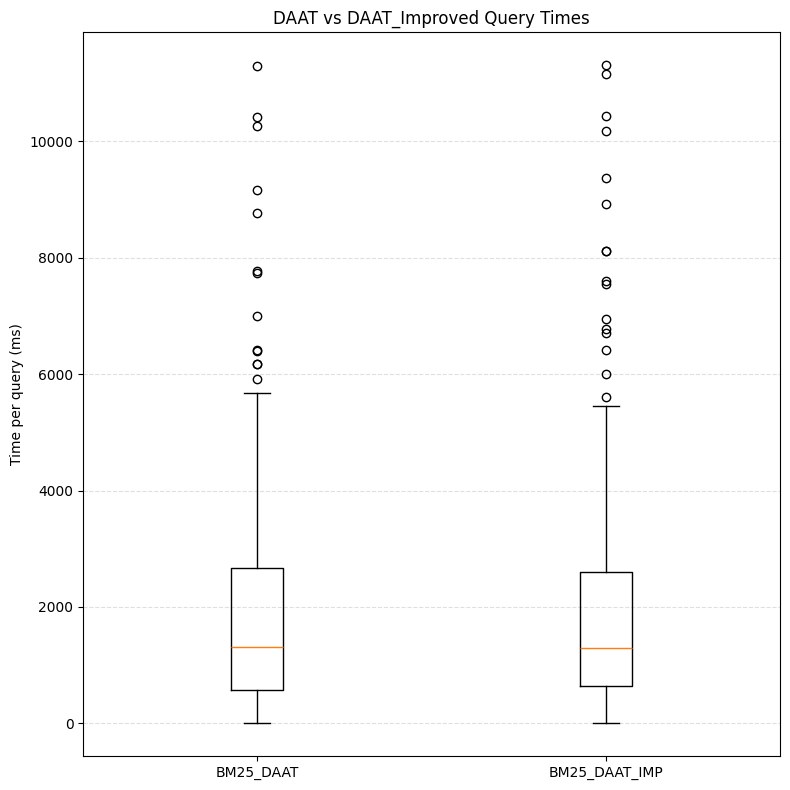

In [ ]:
df_daat_times = pd.merge(df_daat_base_times,df_daat_imp_times, on = "qid", how = "inner")
df_daat_times["t_daat"] *= 1000
df_daat_times["t_imp"]  *= 1000
y_label = "Time (ms)"
plt.figure(figsize=(8, 8))
plt.boxplot(
    [df_daat_times["t_daat"].values, df_daat_times["t_imp"].values],
    tick_labels = ["BM25_DAAT", "BM25_DAAT_IMP"],
    showfliers=True
)
plt.ylabel("Time per query (ms)")
plt.title("DAAT vs DAAT_Improved Query Times")
plt.grid(True, axis = 'y', linestyle = '--', alpha = 0.4)
plt.tight_layout()
plt.show()

In [ ]:
stats_daat = df_daat_times.describe()
stats_daat.columns = ["DAAT", "DAAT_IMP"]
print(stats_daat.T.round(2))

          count     mean      std   min     25%      50%      75%       max
DAAT      200.0  2006.47  2131.94  0.03  576.43  1311.62  2674.23  11302.37
DAAT_IMP  200.0  2073.36  2284.03  0.14  641.93  1293.31  2600.83  11309.71


Upon examining both the boxplots and the descriptive statistics, it is evident that the improved DAAT version performs comparably equal to the baseline, although performance metrics exhibit some variation between the systems.

In [ ]:
from scipy import stats

To statistically validate the claim that the improved system is more efficient than the baseline version, we conducted a statistical test.
Specifically, we selected the Wilcoxon Signed-Rank Test as the most suitable method for this scenario, given its ability to handle paired data and skewed distributions characterized by frequent outliers.
The alternative hypothesis ($H_1$) tested is that the Base DAAT is slower than the Improved DAAT. Consequently, a p-value below the established significance threshold of 0.05 would confirm this hypothesis.

In [ ]:
print(f"{'Comparison':<20} | {'Tested Hypothesis':<25} | {'P-value':<10} | {'Outcome'}")
print("-" * 90)
w = stats.wilcoxon(df_daat_times["t_daat"], df_daat_times["t_imp"], alternative='greater')
print(f"{'t_daat':<8} vs {'t_imp':<8} | {'t_daat > t_imp (Slower)':<25} | {w.pvalue:.2e}     | {'SIGNIFICANT' if w.pvalue < 0.05 else 'NOT_SIGNIFICANT'}")

Comparison           | Tested Hypothesis         | P-value    | Outcome
------------------------------------------------------------------------------------------
t_daat   vs t_imp    | t_daat > t_imp (Slower)   | 9.99e-01     | NOT_SIGNIFICANT


### 9.3 Metrics Evaluation and Effectiveness Statistical Comparison

In [ ]:
def load_results_gz(path):
    path=os.path.join(BASE_PATH,path)
    with gzip.open(path, "rb") as f:
        data = pickle.load(f)
    return data

In [ ]:
daat_base_measures = load_results_gz("BM25_DAAT_results.pickle.gz")
daat_imp_measures  = load_results_gz("BM25_DAAT_IMP_results.pickle.gz")

Since the ranking produced by the improved DAAT is identical to that of the baseline DAAT, we expect that the effectiveness metrics will remain unchanged between the two systems.

In [ ]:
runs_daat = {
    "BM25_DAAT": daat_base_measures,
    "BM25_DAAT_IMP": daat_imp_measures
}
compute_metrics(runs_daat)


        Model  RR(rel=2)     AP     RR  R(rel=2)@10  P(rel=2)@10  nDCG@10   R@10   P@10  AP(rel=2)
    BM25_DAAT     0.6275 0.3494 0.8017       0.2501       0.3444   0.4905 0.1733 0.5759     0.2874
BM25_DAAT_IMP     0.6275 0.3494 0.8017       0.2501       0.3444   0.4905 0.1733 0.5759     0.2874


Statistical significance tests for effectiveness metrics were conducted as a sanity check. However, due to the implementation of the optimization, the retrieval results are identical for both systems. Consequently, the variance of the differences is zero, rendering the t-test p-values undefined (NaN). This empirically confirms that the improved efficiency was achieved without any degradation in retrieval effectiveness.

In [ ]:
df_base_measures = scoredocs_to_df(to_ir_measures(daat_base_measures))
df_imp_measures  = scoredocs_to_df(to_ir_measures(daat_imp_measures))


pt.Experiment(
    [df_base_measures, df_imp_measures],
    topics,
    qrels_df,
    eval_metrics=["ndcg_cut_10", AP_rel2, RR_rel2],
    names=['BM25_DAAT', 'BM25_IMP_DAAT'],
    baseline=0,
    test='t',
    round=4,
    save_dir="./"
)

,name,AP(rel=2),RR(rel=2),ndcg_cut_10,AP(rel=2) +,AP(rel=2) -,AP(rel=2) p-value,RR(rel=2) +,RR(rel=2) -,RR(rel=2) p-value,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value
0,BM25_DAAT,0.2874,0.6275,0.4905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25_IMP_DAAT,0.2874,0.6275,0.4905,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN


## 10. TAAT vs TAAT Improved


### 10.1 Execution of TAAT Improved

We now proceed to compare the baseline TAAT with the improved versions, varying the accumulator parameter.

In [ ]:
accumulators_settings = [10000, 5000, 2000]
taat_experiments = []

In [ ]:
for max_acc in accumulators_settings:
    suffix = "Inf" if max_acc is None else str(max_acc)

    taat_experiments.append({
        "key": f"BM25_TAAT_{suffix}",
        "index": inv_index_bm25,
        "mode": "taat",
        "max_acc": max_acc,
        "expand": False
    })

run_experiments(taat_experiments)

Query processing results already exist. Loading them from disk...

Average times (ms):
BM25_TAAT_10000      -> 726.09 ms
BM25_TAAT_2000       -> 675.32 ms
BM25_TAAT_5000       -> 706.81 ms

All runs completed!


### 10.2 Efficiency Statistical Comparison

We begin with the evaluation of efficiency

In [ ]:
df_taat_base_times = load_times_gz("BM25_TAAT_times.pickle.gz", "t_taat")
df_taat_2k_times  = load_times_gz("BM25_TAAT_2000_times.pickle.gz", "t_2k")
df_taat_5k_times  = load_times_gz("BM25_TAAT_5000_times.pickle.gz", "t_5k")
df_taat_10k_times = load_times_gz("BM25_TAAT_10000_times.pickle.gz", "t_10k")

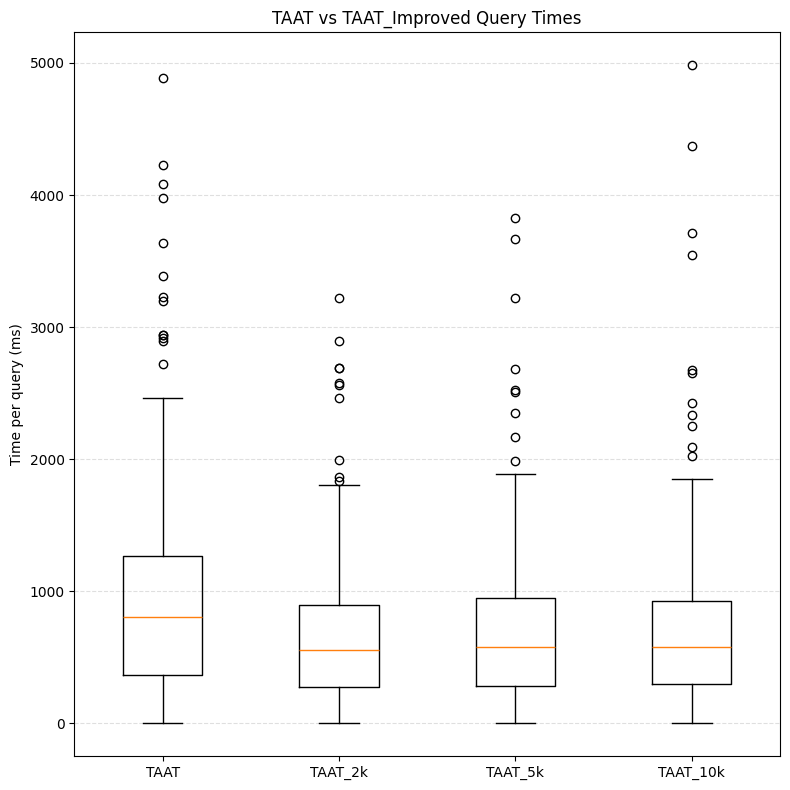

In [ ]:
df_times = [df_taat_base_times, df_taat_2k_times, df_taat_5k_times, df_taat_10k_times]
df_taat_times = reduce(lambda left, right : pd.merge(left, right, on ="qid", how = "inner"), df_times)

cols = ["t_taat", "t_2k", "t_5k", "t_10k"]
labels = ["TAAT", "TAAT_2k", "TAAT_5k", "TAAT_10k"]

for c in cols:
    df_taat_times[c]*=1000

plt.figure(figsize=(8, 8))
plt.boxplot(
    [df_taat_times["t_taat"].values, df_taat_times["t_2k"].values, df_taat_times["t_5k"].values, df_taat_times["t_10k"].values],
    tick_labels = labels,
    showfliers=True
)
plt.ylabel("Time per query (ms)")
plt.title("TAAT vs TAAT_Improved Query Times")
plt.grid(True, axis = 'y', linestyle = '--', alpha = 0.4)
plt.tight_layout()
plt.show()


In [ ]:
stats_taat = df_taat_times.describe()
stats_taat.columns = labels
print(stats_taat.T.round(2))

          count    mean     std   min     25%     50%      75%      max
TAAT      200.0  975.62  884.71  0.07  366.45  805.04  1263.28  4889.45
TAAT_2k   200.0  675.32  598.36  0.03  272.97  552.75   895.46  3219.14
TAAT_5k   200.0  706.81  645.43  0.04  278.93  574.14   948.61  3822.11
TAAT_10k  200.0  726.09  724.11  0.05  296.12  580.68   926.66  4982.69


From the analysis of the boxplots and the computed statistics, it is evident that the improved TAAT implementations shift the time distribution towards lower values. Both the average execution time and the maximum peaks decrease significantly. While this indicates a clear performance gap between the baseline and the optimized models, the data suggests that the differences between the various improved configurations (2k, 5k, 10k) are smaller.

To make definitive claims, we must conduct statistical tests. We initially perform the Friedman test, a non-parametric test that allows us to determine if there are significant differences among the four TAAT variants.

In [ ]:
stat, p_value = stats.friedmanchisquare(df_taat_times["t_taat"], df_taat_times["t_2k"], df_taat_times["t_5k"], df_taat_times["t_10k"])
print(f"{'Comparison':<20} | {'Tested Hypothesis':<30} | {'P-value':<10} | {'Outcome'}")
print("-" * 85)


print(f"{"All TAAT Variants":<20} | {"At least one differs":<30} | {p_value:.2e}     | {'SIGNIFICANT' if p_value < 0.05 else 'NOT_SIGNIFICANT'}")

Comparison           | Tested Hypothesis              | P-value    | Outcome
-------------------------------------------------------------------------------------
All TAAT Variants    | At least one differs           | 2.54e-39     | SIGNIFICANT


The Friedman test yields an extremely low p-value ($p < 0.05$), allowing us to reject the null hypothesis and confirm that statistically significant differences exist among the four algorithms. However it does not identify which specific pairs of algorithms differ.

To identify specific differences, we conduct Wilcoxon tests between the algorithms.

Specifically, we perform 6 statistical tests to evaluate all possible pairwise combinations. To ensure validity, we must apply the Bonferroni correction. This is necessary because when performing multiple tests, the probability of committing a Type I error (rejecting the null hypothesis when it is actually true) increases according to the formula:$$P = 1 - (1 - \alpha)^k$$Where $\alpha$ is the significance level and $k$ is the number of tests performed (in our case, $\alpha = 0.05$ and $k = 6$). Consequently, the probability of committing a Type I error in our scenario is:$$ P = 1 - ( 1- 0.05)^6 = 0.2649 = 26.49\%$$Specifically, the Bonferroni correction adjusts the significance threshold $\alpha$ as follows:$$\alpha_{Bonf} = 1 - (1 - \alpha)^\frac{1}{k} \approx \frac{\alpha}{k}$$In our specific case, we obtain:$$\alpha_{Bonf} = \frac{0.05}{6} \approx 0.0083$$Naturally, a test performed with the Bonferroni correction is significantly more stringent and may increase the risk of Type II errors (failing to reject the null hypothesis when it is actually false). However, in this context, we prefer to maintain a stricter test to avoid potential Type I errors, although less stringent corrections could alternatively be applied.
The conducted tests are divided into two categories:
1) Comparison between Baseline TAAT and Improved TAAT
    - Improved TAAT vs. Baseline TAAT: We hypothesize that the Baseline TAAT has worse efficiency, resulting in longer query execution times ($H_1 : Time_{base} > Time_{imp}$).
2) Comparison among Improved TAAT versions
    - TAAT 2k vs. TAAT 5k (and TAAT 10k): We hypothesize that the TAAT 2k is more efficient than the other two configurations ($H_1 : Time_{2k} < Time_{5k} \ [Time_{10k}]$).
    - TAAT 5k vs. TAAT 10k: We hypothesize that the TAAT 5k is more efficient than the TAAT 10k ($H_1 : Time_{5k} < Time_{10k}$).

In [ ]:
pairs = list(itertools.combinations(cols,2))

alpha = 0.05
alpha_corrected = alpha / len(pairs)

print(f"Bonferroni Threshold (Corrected Alpha): {alpha_corrected:.6f}")
print("-" * 90)
print(f"{'Comparison':<20} | {'Tested Hypothesis':<25} | {'P-value':<10} | {'Outcome'}")
print("-" * 90)

for taat_1 , taat_2 in pairs:
    if taat_1 == "t_taat":
        alt = 'greater'
        hypothesis_desc = f"{taat_1} > {taat_2} (Slower)"
    else:
        alt = 'less'
        hypothesis_desc = f"{taat_1} < {taat_2} (Faster)"

    stat , p = stats.wilcoxon(df_taat_times[taat_1] , df_taat_times[taat_2], alternative=alt)

    sig_str = "SIGNIFICANT" if p < alpha_corrected else "NOT_SIGNIFICANT"

    print(f"{taat_1:<8} vs {taat_2:<8} | {hypothesis_desc:<25} | {p:.2e}     | {sig_str}")

Bonferroni Threshold (Corrected Alpha): 0.008333
------------------------------------------------------------------------------------------
Comparison           | Tested Hypothesis         | P-value    | Outcome
------------------------------------------------------------------------------------------
t_taat   vs t_2k     | t_taat > t_2k (Slower)    | 2.16e-27     | SIGNIFICANT
t_taat   vs t_5k     | t_taat > t_5k (Slower)    | 1.16e-21     | SIGNIFICANT
t_taat   vs t_10k    | t_taat > t_10k (Slower)   | 1.63e-19     | SIGNIFICANT
t_2k     vs t_5k     | t_2k < t_5k (Faster)      | 1.54e-04     | SIGNIFICANT
t_2k     vs t_10k    | t_2k < t_10k (Faster)     | 1.48e-07     | SIGNIFICANT
t_5k     vs t_10k    | t_5k < t_10k (Faster)     | 7.61e-03     | SIGNIFICANT


Based on the obtained results, we can make the following assertions:
1) The Baseline TAAT is statistically less efficient than the improved versions, confirming our initial expectations.
2) The TAAT configuration with the accumulator parameter set to 2000 is statistically more efficient than the corresponding improved versions with parameters set to 5000 and 10000.
3) The TAAT with the accumulator parameter set to 5000 is statistically more efficient than the TAAT with the parameter set to 10000.

Consequently, based on these statistical tests, we can rank these algorithms by efficiency, in ascending order from the lowest to the highest query execution time:
$$ TAAT_{2k} \ < \ TAAT_{5k} \ < \ TAAT_{10k} \ < \ TAAT_{base} $$

### 10.3 Metrics Evaluation and Effectiveness Statistical Comparison

We now proceed to evaluate the effectiveness to determine if there are any statistically significant variations.

In [ ]:
taat_base_measures = load_results_gz("BM25_TAAT_results.pickle.gz")
taat_2k_measures  = load_results_gz("BM25_TAAT_2000_results.pickle.gz")
taat_5k_measures  = load_results_gz("BM25_TAAT_5000_results.pickle.gz")
taat_10k_measures = load_results_gz("BM25_TAAT_10000_results.pickle.gz")

In [ ]:
runs_taat = {
    "BM25_TAAT": taat_base_measures,
    "BM25_TAAT_2000": taat_2k_measures,
    "BM25_TAAT_5000": taat_5k_measures,
    "BM25_TAAT_10000": taat_10k_measures
}
compute_metrics(runs_taat)

          Model  RR(rel=2)     AP     RR  R(rel=2)@10  P(rel=2)@10  nDCG@10   R@10   P@10  AP(rel=2)
      BM25_TAAT     0.6275 0.3494 0.8017       0.2501       0.3444   0.4905 0.1733 0.5759     0.2874
 BM25_TAAT_2000     0.6309 0.3639 0.8048       0.2559       0.3519   0.4979 0.1750 0.5852     0.2940
 BM25_TAAT_5000     0.6308 0.3616 0.8048       0.2540       0.3500   0.4968 0.1747 0.5833     0.2938
BM25_TAAT_10000     0.6307 0.3588 0.8048       0.2503       0.3463   0.4926 0.1736 0.5778     0.2912


In [ ]:
df_taat_2k  = scoredocs_to_df(to_ir_measures(taat_2k_measures))
df_taat_5k  = scoredocs_to_df(to_ir_measures(taat_5k_measures))
df_taat_10k = scoredocs_to_df(to_ir_measures(taat_10k_measures))


pt.Experiment(
    [df_taat_2k, df_bm25_taat,df_taat_5k, df_taat_10k],
    topics,
    qrels_df,
    eval_metrics=["ndcg_cut_10", AP_rel2, RR_rel2],
    names=['BM25_TAAT_2000', 'BM25_TAAT_BASE','BM25_TAAT_5000', 'BM25_TAAT_10000'],
    baseline=0,
    test='t',
    correction='b',
    correction_alpha=0.05,
    round=4,
    save_dir="./"
)


,name,AP(rel=2),RR(rel=2),ndcg_cut_10,AP(rel=2) +,AP(rel=2) -,AP(rel=2) p-value,AP(rel=2) reject,AP(rel=2) p-value corrected,RR(rel=2) +,RR(rel=2) -,RR(rel=2) p-value,RR(rel=2) reject,RR(rel=2) p-value corrected,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value,ndcg_cut_10 reject,ndcg_cut_10 p-value corrected
0,BM25_TAAT_2000,0.2940,0.6309,0.4979,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN
1,BM25_TAAT_BASE,0.2874,0.6275,0.4905,10.0,30.0,0.256676,False,0.770029,0.0,4.0,0.268585,False,0.805756,1.0,2.0,0.239198,False,0.717595
2,BM25_TAAT_5000,0.2938,0.6308,0.4968,4.0,16.0,0.951931,False,1.000000,0.0,2.0,0.170390,False,0.511170,0.0,1.0,0.321854,False,0.965563
3,BM25_TAAT_10000,0.2912,0.6307,0.4926,6.0,18.0,0.567633,False,1.000000,0.0,3.0,0.155199,False,0.465598,0.0,1.0,0.321854,False,0.965563


As we can observe, the effectiveness metrics remain largely stable across the different algorithms. By performing statistical tests with PyTerrier and using the model with 2000 accumulators as the baseline, we find no significant differences compared to the other models. Consequently, we cannot reject the null hypothesis.

Given that there are no statistically significant differences in effectiveness among the models, we select the TAAT configuration with 2000 accumulators as the optimal model. This choice is motivated by the fact that it proved to be the most efficient in terms of execution time while maintaining comparable retrieval quality.

## 11. Query Expansion on TAAT and DAAT

Building upon the results of the previous analysis, we now proceed to apply Query Expansion techniques to the optimal configurations identified for both the DAAT and TAAT algorithms.

### 11.1 Execution of TAAT and DAAT with Query Expansion

In [ ]:
QE_experiments = [

  {
    "key": "BM25_DAAT_IMP_QE",
    "index": inv_index_bm25,
    "mode": "daat_improved",
    "max_acc": None,
    "expand": True,
    "dir_index_topk": direct_mm,
    "termid2term": termid2term,
    "fb_docs": 10,
    "fb_terms": 3,
    "alpha": 0.3,
    "in_memory": False,  # set True if the direct index fits in memory
    "verbose": False
},


{
    "key": "BM25_TAAT_2000_QE",
    "index": inv_index_bm25,
    "mode": "taat",
    "max_acc": 2000,
    "expand": True,
    "dir_index_topk": direct_mm,
    "termid2term": termid2term,
    "fb_docs": 10,
    "fb_terms": 3,
    "alpha": 0.3,
    "in_memory": False,  # set True if the direct index fits in memory
    "verbose": False
}
]
run_experiments(QE_experiments)

Query processing results already exist. Loading them from disk...

Average times (ms):
BM25_DAAT_IMP_QE     -> 3932.94 ms
BM25_TAAT_2000_QE    -> 1216.19 ms

All runs completed!


In [ ]:
df_taat_QE_times = load_times_gz("BM25_TAAT_2000_QE_times.pickle.gz", "t_taat_qe")
df_daat_QE_times = load_times_gz("BM25_DAAT_IMP_QE_times.pickle.gz", "t_daat_qe")

In [ ]:
df_times = [df_taat_2k_times, df_taat_QE_times, df_daat_imp_times, df_daat_QE_times]
df_qe_times = reduce(lambda left, right : pd.merge(left, right, on ="qid", how = "inner"), df_times)

cols = ["t_2k", "t_taat_qe", "t_imp", "t_daat_qe"]
labels = ["TAAT_2k", "TAAT_2k_QE", "DAAT_IMP", "DAAT_IMP_QE"]
for c in cols:
    df_qe_times[c]*=1000

### 11.2 TAAT_2000 vs TAAT_2000 with Query Expansion

#### 11.2.1 Efficiency Evaluation and Statistical Analysis

In terms of efficiency, we expect that Query Expansion will introduce significant computational overhead, thereby noticeably increasing query execution times.

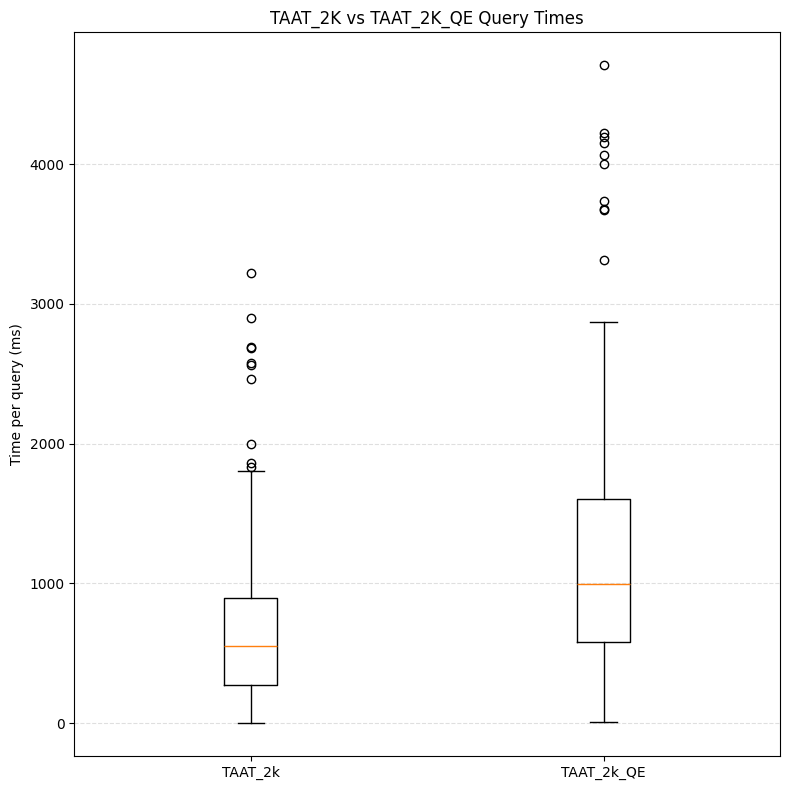

In [ ]:
labels_taat = ["TAAT_2k", "TAAT_2k_QE"]
plt.figure(figsize=(8, 8))
plt.boxplot(
    [df_qe_times["t_2k"].values, df_qe_times["t_taat_qe"].values],
    tick_labels = labels_taat,
    showfliers=True
)

plt.ylabel("Time per query (ms)")
plt.title("TAAT_2K vs TAAT_2K_QE Query Times")
plt.grid(True, axis = 'y', linestyle = '--', alpha = 0.4)
plt.tight_layout()
plt.show()

In [ ]:
stats_taat_qe = df_qe_times[["t_2k", "t_taat_qe"]].describe()
stats_taat_qe.columns = labels_taat
print(stats_taat_qe.T.round(2))

            count     mean     std   min     25%     50%      75%      max
TAAT_2k     200.0   675.32  598.36  0.03  272.97  552.75   895.46  3219.14
TAAT_2k_QE  200.0  1216.19  921.84  9.46  581.34  994.92  1603.48  4706.72


In [ ]:
print(f"{'Comparison':<20} | {'Tested Hypothesis':<25} | {'P-value':<10} | {'Outcome'}")
print("-" * 90)
w = stats.wilcoxon(df_qe_times["t_taat_qe"], df_qe_times["t_2k"], alternative='greater')
print(f"{'t_taat_qe':<8} vs {'t_2k':<8} | {'t_taat_qe > t_2k (Slower)':<25} | {w.pvalue:.2e}     | {'SIGNIFICANT' if w.pvalue < 0.05 else 'NOT_SIGNIFICANT'}")

Comparison           | Tested Hypothesis         | P-value    | Outcome
------------------------------------------------------------------------------------------
t_taat_qe vs t_2k     | t_taat_qe > t_2k (Slower) | 2.73e-34     | SIGNIFICANT


As hypothesized, the efficiency of the system utilizing Query Expansion deteriorates significantly compared to the baseline configuration. The analysis of the boxplots, combined with descriptive statistics and the statistical test results, highlights a sharp distinction between the two systems, confirming a substantial increase in response times for the expanded model.

This performance degradation was anticipated and is intrinsic to the methodology: the expansion algorithm necessitates a two-stage retrieval process executing the original query for feedback followed by the expanded query along with intermediate steps for term re-weighting. This computational overhead inevitably results in higher latency.

#### 11.2.2 Metrics Evaluation and Effectiveness Statistical Comparison

We now proceed to evaluate the effectiveness. In this context, we expect an improvement in several metrics, particularly Recall, as the primary purpose of Query Expansion is to retrieve relevant documents that were previously missed.

In [ ]:
taat_2k_QE_measures  = load_results_gz("BM25_TAAT_2000_QE_results.pickle.gz")

In [ ]:
runs_taat_qe = {
    "BM25_TAAT_2000": taat_2k_measures,
    "BM25_TAAT_2000_QE": taat_2k_QE_measures
}
compute_metrics(runs_taat_qe)

            Model  RR(rel=2)     AP     RR  R(rel=2)@10  P(rel=2)@10  nDCG@10   R@10   P@10  AP(rel=2)
   BM25_TAAT_2000     0.6309 0.3639 0.8048       0.2559       0.3519   0.4979 0.1750 0.5852      0.294
BM25_TAAT_2000_QE     0.5156 0.3566 0.7062       0.2445       0.3556   0.4610 0.1544 0.5593      0.283


For the statistical analysis, we selected a specific set of metrics tailored to evaluate the quality of Query Expansion. Specifically, we focused on nDCG@10 and MAP (and Average Precision with relevance threshold $\ge$ 2) to assess ranking quality, while introducing Recall@1000 to explicitly measure the improvement in retrieving relevant documents that were previously missed.



In [ ]:
df_taat_2k_QE = scoredocs_to_df(to_ir_measures(taat_2k_QE_measures))

pt.Experiment(
    [df_taat_2k, df_taat_2k_QE],
    topics,
    qrels_df,
    eval_metrics=["ndcg_cut_10", "recall_1000" ,"map",AP_rel2],
    names=['BM25_TAAT_2000', 'BM25_TAAT_2000_QE'],
    baseline=0,
    test='t',
    round=4,
    save_dir="./"
)

,name,map,recall_1000,ndcg_cut_10,AP(rel=2),map +,map -,map p-value,recall_1000 +,recall_1000 -,recall_1000 p-value,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value,AP(rel=2) +,AP(rel=2) -,AP(rel=2) p-value
0,BM25_TAAT_2000,0.3639,0.7446,0.4979,0.294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25_TAAT_2000_QE,0.3566,0.7663,0.4610,0.283,23.0,31.0,0.629252,11.0,0.0,0.056703,20.0,33.0,0.070209,27.0,27.0,0.462484


Applying Query Expansion resulted in a little increase in Recall@1000, confirming its utility in retrieving relevant documents that were previously missed. However, this improvement was offset by a decrease in nDCG@10, attributable to query drift. Statistical tests indicate that these performance variations are not significant compared to the baseline.

A possible explanation for these results lies in the interaction between the pruned TAAT algorithm and Query Expansion. Specifically, our pruning implementation imposes a hard limit on the number of documents that can be maintained in the accumulators. However, since Query Expansion adds multiple terms to the query, the number of matching documents increases significantly. Consequently, if the accumulator threshold is set too low, the buffer tends to saturate much earlier, leading to the potential loss of relevant documents that fail to enter the ranking.

To verify this hypothesis, we will apply Query Expansion by setting the accumulator limit to 10,000, and subsequently by removing the constraint entirely, effectively reverting to the original unpruned TAAT

In [ ]:
QE_experiments2 = [
{
    "key": "BM25_TAAT_10000_QE",
    "index": inv_index_bm25,
    "mode": "taat",
    "max_acc": 10000,
    "expand": True,
    "dir_index_topk": direct_mm,
    "termid2term": termid2term,
    "fb_docs": 10,
    "fb_terms": 3,
    "alpha": 0.3,
    "in_memory": False,  # set True if the direct index fits in memory
    "verbose": False
},
{
    "key": "BM25_TAAT_QE",
    "index": inv_index_bm25,
    "mode": "taat",
    "max_acc": None,
    "expand": True,
    "dir_index_topk": direct_mm,
    "termid2term": termid2term,
    "fb_docs": 10,
    "fb_terms": 3,
    "alpha": 0.3,
    "in_memory": False,  # set True if the direct index fits in memory
    "verbose": False
}
]
run_experiments(QE_experiments2)

Query processing results already exist. Loading them from disk...

Average times (ms):
BM25_TAAT_10000_QE   -> 1313.15 ms
BM25_TAAT_QE         -> 2076.07 ms

All runs completed!


In [ ]:
taat_10k_QE_measures = load_results_gz("BM25_TAAT_10000_QE_results.pickle.gz")
taat_QE_measures = load_results_gz("BM25_TAAT_QE_results.pickle.gz")

In [ ]:
runs_taat_qe = {
    "BM25_TAAT_2000": taat_2k_measures,
    "BM25_TAAT_2000_QE": taat_2k_QE_measures,
    "BM25_TAAT_10000_QE": taat_10k_QE_measures,
    "BM25_TAAT_QE": taat_QE_measures

}
compute_metrics(runs_taat_qe)

             Model  RR(rel=2)     AP     RR  R(rel=2)@10  P(rel=2)@10  nDCG@10   R@10   P@10  AP(rel=2)
    BM25_TAAT_2000     0.6309 0.3639 0.8048       0.2559       0.3519   0.4979 0.1750 0.5852     0.2940
 BM25_TAAT_2000_QE     0.5156 0.3566 0.7062       0.2445       0.3556   0.4610 0.1544 0.5593     0.2830
BM25_TAAT_10000_QE     0.5118 0.3579 0.7115       0.2571       0.3722   0.4742 0.1619 0.5833     0.2893
      BM25_TAAT_QE     0.5227 0.3555 0.7249       0.2510       0.3667   0.4747 0.1630 0.5889     0.2819


In [ ]:
df_taat_2k_QE = scoredocs_to_df(to_ir_measures(taat_2k_QE_measures))
df_taat_10k_QE = scoredocs_to_df(to_ir_measures(taat_10k_QE_measures))
df_taat_QE = scoredocs_to_df(to_ir_measures(taat_QE_measures))
pt.Experiment(
    [df_taat_2k,df_taat_2k_QE,df_taat_10k_QE,df_taat_QE],
    topics,
    qrels_df,
    eval_metrics=["ndcg_cut_10", "recall_1000" ,"map",AP_rel2],
    names=['BM25_TAAT_2000','BM25_TAAT_2000_QE','BM25_TAAT_10000_QE','BM25_TAAT_QE'],
    baseline=0,
    test='t',
    correction = 'b',
    round=4,
    save_dir="./"
)

,name,map,recall_1000,ndcg_cut_10,AP(rel=2),map +,map -,map p-value,map reject,map p-value corrected,recall_1000 +,recall_1000 -,recall_1000 p-value,recall_1000 reject,recall_1000 p-value corrected,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value,ndcg_cut_10 reject,ndcg_cut_10 p-value corrected,AP(rel=2) +,AP(rel=2) -,AP(rel=2) p-value,AP(rel=2) reject,AP(rel=2) p-value corrected
0,BM25_TAAT_2000,0.3639,0.7446,0.4979,0.2940,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN
1,BM25_TAAT_2000_QE,0.3566,0.7663,0.4610,0.2830,23.0,31.0,0.629252,False,1.0,11.0,0.0,0.056703,False,0.170110,20.0,33.0,0.070209,False,0.210628,27.0,27.0,0.462484,False,1.0
2,BM25_TAAT_10000_QE,0.3579,0.7736,0.4742,0.2893,25.0,29.0,0.683437,False,1.0,14.0,4.0,0.022817,False,0.068451,24.0,29.0,0.253054,False,0.759161,27.0,27.0,0.757888,False,1.0
3,BM25_TAAT_QE,0.3555,0.7547,0.4747,0.2819,29.0,25.0,0.587832,False,1.0,18.0,19.0,0.617339,False,1.000000,23.0,30.0,0.292420,False,0.877259,29.0,25.0,0.471148,False,1.0


The experiment confirms that the TAAT algorithm with **2k accumulators** experiences *saturation* when combined with Query Expansion, leading to nDCG degradation due to resource contention. By relaxing the parameter to **10k accumulators**, a distinct **Beneficial Pruning** effect emerges: this configuration achieves the highest global **Recall@1000** (0.7736), outperforming even the unpruned system. However, it is important to note that **statistical tests (with Bonferroni correction) did not detect significant differences** among the configurations. Consequently, while the 10k model shows a strong positive trend in effectiveness compared to the baseline, these improvements are not statistically distinguishable under strict testing conditions.

### 11.3 DAAT_IMPROVED vs DAAT_IMPROVED with Query Expansion

#### 11.3.1 Efficiency Evaluation and Statistical Analysis

We can apply the exact same considerations regarding efficiency to the DAAT algorithm as we did for TAAT.

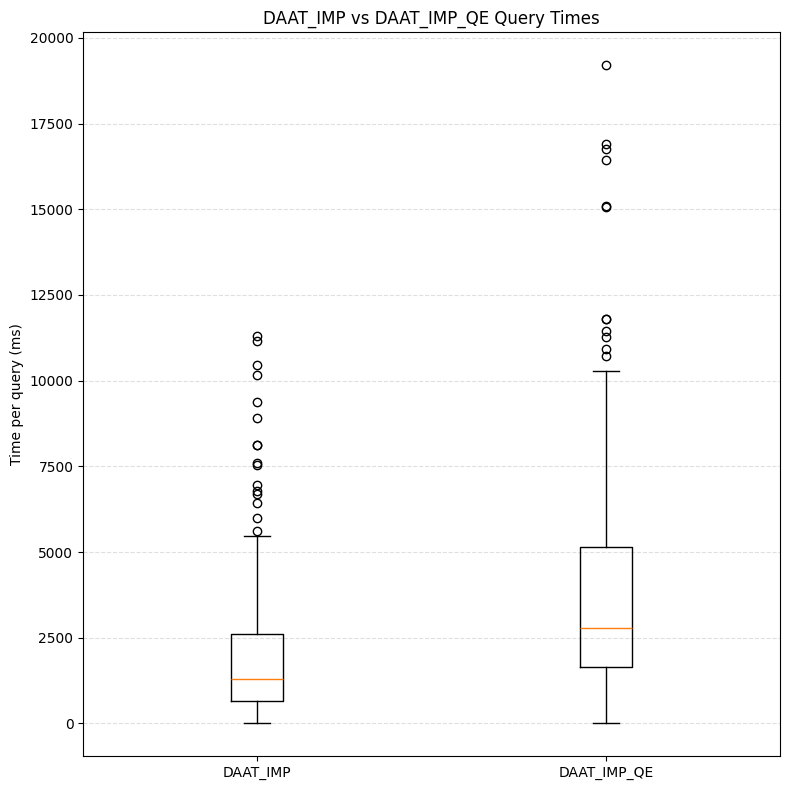

In [ ]:
labels_daat = ["DAAT_IMP", "DAAT_IMP_QE"]
plt.figure(figsize=(8, 8))
plt.boxplot(
    [df_qe_times["t_imp"].values, df_qe_times["t_daat_qe"].values],
    tick_labels = labels_daat,
    showfliers=True
)

plt.ylabel("Time per query (ms)")
plt.title("DAAT_IMP vs DAAT_IMP_QE Query Times")
plt.grid(True, axis = 'y', linestyle = '--', alpha = 0.4)
plt.tight_layout()
plt.show()

In [ ]:
stats_daat_qe = df_qe_times[["t_imp", "t_daat_qe"]].describe()
stats_daat_qe.columns = labels_daat
print(stats_daat_qe.T.round(2))

             count     mean      std    min      25%      50%      75%       max
DAAT_IMP     200.0  2073.36  2284.03   0.14   641.93  1293.31  2600.83  11309.71
DAAT_IMP_QE  200.0  3932.94  3489.94  17.80  1650.55  2794.06  5132.61  19201.92


In [ ]:
print(f"{'Comparison':<20} | {'Tested Hypothesis':<25} | {'P-value':<10} | {'Outcome'}")
print("-" * 90)
w = stats.wilcoxon(df_qe_times["t_daat_qe"], df_qe_times["t_imp"], alternative='greater')
print(f"{'t_daat_qe':<8} vs {'t_imp':<8} | {'t_daat_qe > t_imp (Slower)':<25} | {w.pvalue:.2e}     | {'SIGNIFICANT' if w.pvalue < 0.05 else 'NOT_SIGNIFICANT'}")

Comparison           | Tested Hypothesis         | P-value    | Outcome
------------------------------------------------------------------------------------------
t_daat_qe vs t_imp    | t_daat_qe > t_imp (Slower) | 7.18e-35     | SIGNIFICANT


#### 11.3.2 Metrics Evaluation and Effectiveness Statistical Comparison

In [ ]:
daat_imp_QE_measures = load_results_gz("BM25_DAAT_IMP_QE_results.pickle.gz")

In [ ]:
runs_daat_qe ={
    "BM25_DAAT_IMP": daat_imp_measures,
    "BM25_DAAT_IMP_QE": daat_imp_QE_measures
}
compute_metrics(runs_daat_qe)

           Model  RR(rel=2)     AP     RR  R(rel=2)@10  P(rel=2)@10  nDCG@10   R@10   P@10  AP(rel=2)
   BM25_DAAT_IMP     0.6275 0.3494 0.8017       0.2501       0.3444   0.4905 0.1733 0.5759     0.2874
BM25_DAAT_IMP_QE     0.5227 0.3555 0.7249       0.2510       0.3667   0.4747 0.1630 0.5889     0.2819


In [ ]:
df_daat_imp_QE = scoredocs_to_df(to_ir_measures(daat_imp_QE_measures))

pt.Experiment(
    [df_imp_measures, df_daat_imp_QE],
    topics,
    qrels_df,
    eval_metrics=["ndcg_cut_10", "recall_1000" ,"map",AP_rel2],
    names=['BM25_DAAT_IMP', 'BM25_DAAT_IMP_QE'],
    baseline=0,
    test='t',
    round=4,
    save_dir="./"
)

,name,map,recall_1000,ndcg_cut_10,AP(rel=2),map +,map -,map p-value,recall_1000 +,recall_1000 -,recall_1000 p-value,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value,AP(rel=2) +,AP(rel=2) -,AP(rel=2) p-value
0,BM25_DAAT_IMP,0.3494,0.7442,0.4905,0.2874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25_DAAT_IMP_QE,0.3555,0.7547,0.4747,0.2819,31.0,23.0,0.65196,6.0,3.0,0.192811,23.0,30.0,0.438705,29.0,25.0,0.712396


Applying Query Expansion to the DAAT algorithm leads to a general improvement in retrieval metrics, with the exception of nDCG@10, which exhibits a slight expected decrease. This trend suggests that the expansion module is effectively retrieving a larger pool of relevant documents. However, statistical testing reveals no significant differences, preventing us from definitively claiming that the expanded system is statistically superior to the baseline in terms of effectiveness.

### 11.4 Query Expansion Improvements



We observed that Query Expansion (QE) significantly improves **Recall** but can negatively impact precision-oriented metrics such as **nDCG@10**. Consequently, we proposed specific refinements to the QE process to mitigate its primary drawback: **Topic Drift**.

Topic drift occurs when expansion terms shift the semantic focus of the query away from the user's original intent, leading to the retrieval of documents that are relevant to the expanded query but irrelevant to the original one. To address this issue, we implemented three main improvements:

 1. **Rank-Biased Term Weighting:**
When selecting terms for the expanded query, greater weight is assigned to terms appearing in top-ranked documents from the initial retrieval. Specifically, a decay factor is applied based on the document's rank:

$$
decay = \frac{1}{1 + document\_rank}
$$

For instance, the top-ranked document (rank 0) retains a decay factor of 1.0 (no penalty), while the second document (rank 1) has its term weights scaled by a factor of 0.5.

 2. **Minimum Quality Threshold (QPP Filter):**
Extracting useful expansion terms is difficult when the initial retrieval yields poor results (i.e., when even the top-ranked document has a very low score). Proceeding with QE in such cases significantly increases the risk of topic drift. Therefore, we established a minimum quality threshold of **12** for the top document's score. If the top score falls below this threshold, the Query Expansion process is skipped entirely.

 3. **Dynamic $\alpha$ Weighting (Boosting & Damping):**
Consistent with the logic above, the reliance on the expanded terms (controlled by the parameter $\alpha$) is adjusted dynamically based on the confidence in the initial retrieval. If the top document has a high score, we place more trust in the expansion; if the score is low, we rely on it less.

While the default parameter is $\alpha = 0.3$, we modified it based on the following heuristic thresholds:

* $Top\ score > 35 \rightarrow \alpha = 0.4$ (**Boost**)
* $18 < Top\ score \leq 35 \rightarrow \alpha = 0.3$ (**Standard**)
* $12 < Top\ score \leq 18 \rightarrow \alpha = 0.15$ (**Damping**)

*Note: All thresholds were determined heuristically.*

In [ ]:
def select_expansion_terms(query,
                           top_docs,
                           index,
                           dir_index_topk,
                           id2term,
                           fb_docs=10,
                           fb_terms=3,
                           in_memory=False):
    """
    Selects expansion terms using the top-k direct index.

    Parameters:
      - query: original query string
      - top_docs: [(score, internal_docid), ...] (result of the first run)
      - index: InvertedIndex (to access df, N, etc.)
      - dir_index_topk: The direct index structure
      - id2term: mapping from termid to term string
      - fb_docs: number of documents to use for feedback
      - fb_terms: number of expansion terms to return

    Uses:
      - dir_index_topk[docid] = [(termid, tf), ...]
      - id2term[termid] -> term (string)
    """
    qtokens = set(preprocess(query))
    term_counter = Counter()

    # 1) accumulate terms from the top fb_docs documents with the rank position
    for rank, (score, internal_id) in enumerate(top_docs[:fb_docs]):
        docid = int(internal_id)

        # Calculate decay
        # Doc 1 -> rank 0 -> decay 1.0
        # Doc 2 -> rank 1 -> decay 0.5
        # Doc 2 -> rank 2 -> decay 0.333
        # ...
        # Doc 10 -> rank 9 -> decay 0.1
        decay = 1.0 / (rank + 1)

        if in_memory:
            topk_pairs = dir_index_topk[docid]
        else:
            topk_pairs = get_doc_topk_from_memmap(docid, dir_index_topk)

        for termid, tf in topk_pairs:
            term = id2term[termid]
            if term in qtokens:
                continue
            # More weight to words in the documents with better rank
            term_counter[term] += (tf * decay)

    if not term_counter:
        return []

    # 2) keep only terms present in the lexicon
    cleaned = {}
    for term, weighted_tf in term_counter.items():
        if term not in index.lexicon:
            continue
        cleaned[term] = 1 + math.log(weighted_tf) if weighted_tf > 0 else 0

    if not cleaned:
        return []

    # 3) Scoring (Weighted TF) * IDF
    scored_terms = []
    N = index.stats["num_docs"]

    for term, w_tf in cleaned.items():

        termid, df, coll_freq = index.lexicon[term]
        idf = math.log((N / (df + 1.0)) + 1.0)
        scored_terms.append((term, w_tf * idf))

    scored_terms.sort(key=lambda x: x[1], reverse=True)
    expansion_terms = [t for t, s in scored_terms[:fb_terms]]

    return expansion_terms

In [ ]:
def query_process(query,
                  index,
                  mode="taat",
                  k=1000,
                  max_accumulators=None,
                  expand=False,
                  doc_topk_terms=None,
                  termid2term=None,
                  fb_docs=None,
                  fb_terms=None,
                  alpha=None,
                  in_memory=False,
                  verbose=False):
    """
    Pseudo Relevance Feedback with QPP Filter and Dynamic Alpha.
    """
    # 1) Initial run
    if verbose:
        print(f"Received query: {query}")

    if not expand:
        initial_k = k
    else:
        # We need enough docs to perform feedback
        initial_k = max(fb_docs, k)

    orig_results = query_process_executor(query, index, mode, k=initial_k, max_accumulators=max_accumulators)

    if not orig_results:
        if verbose:
            print("No results found for the original query.")
        return []

    if not expand:
        return orig_results[:k]

    # We check the score of the top document to decide if expansion can be useful
    top_score = orig_results[0][0]

    SCORE_THRESHOLD = 12.0  # Quality Threshold

    if top_score < SCORE_THRESHOLD:
        if verbose:
            print(f"Skipping QE: Top score {top_score:.2f} below threshold {SCORE_THRESHOLD}. Avoiding Topic Drift.")
        return orig_results[:k]

    # 2) Select expansion terms
    expansion_terms = select_expansion_terms(
        query,
        orig_results,
        index,
        doc_topk_terms,
        termid2term,
        fb_docs=fb_docs,
        fb_terms=fb_terms,
        in_memory=in_memory
    )

    if not expansion_terms:
        if verbose:
            print("No expansion terms found.")
        return orig_results[:k]

    if verbose:
        print(f"Expansion terms: {expansion_terms}")

    # 3) Run with expanded query
    qe_query = query + " " + " ".join(expansion_terms)
    if verbose:
        print(f"Expanded query: {qe_query}")

    qe_results = query_process_executor(qe_query, index, mode, k=k, max_accumulators=max_accumulators)

    # Adjust alpha based on the score of the initial retrieval
    current_alpha = alpha # Default value

    if top_score > 35.0:
        # First document with high score -> Boost expansion weight
        current_alpha = 0.4

    elif top_score > 18.0:
        # First document with medium score -> Keep base alpha
        current_alpha = 0.3

    else:
        # First document with low score -> Dampening expansion weight
        current_alpha = 0.15

    # 4) Mix results
    mixed_results = mix_results(orig_results, qe_results, alpha=current_alpha, k=k)

    return mixed_results

#### 11.4.1 Execution of TAAT and DAAT with Improved Query Expansion

In [ ]:
QE_experiments_v2 = [

  {
    "key": "BM25_DAAT_IMP_QE_V2",
    "index": inv_index_bm25,
    "mode": "daat_improved",
    "max_acc": None,
    "expand": True,
    "dir_index_topk": direct_mm,
    "termid2term": termid2term,
    "fb_docs": 10,
    "fb_terms": 3,
    "alpha": 0.3,
    "in_memory": False,  # set True if the direct index fits in memory
    "verbose": False
},


{
    "key": "BM25_TAAT_10000_QE_V2",
    "index": inv_index_bm25,
    "mode": "taat",
    "max_acc": 10000,
    "expand": True,
    "dir_index_topk": direct_mm,
    "termid2term": termid2term,
    "fb_docs": 10,
    "fb_terms": 3,
    "alpha": 0.3,
    "in_memory": False,  # set True if the direct index fits in memory
    "verbose": False
}
]
run_experiments(QE_experiments_v2)

Query processing results already exist. Loading them from disk...

Average times (ms):
BM25_DAAT_IMP_QE_V2  -> 4085.10 ms
BM25_TAAT_10000_QE_V2 -> 1293.92 ms

All runs completed!


#### 11.4.2 TAAT Efficiency Evaluation and Statistical Analysis

In [ ]:
taat_10k_QE_measures_v2  = load_results_gz("BM25_TAAT_10000_QE_V2_results.pickle.gz")

In [ ]:
runs_taat_qe = {
    "BM25_TAAT_10000_QE_V2": taat_10k_QE_measures,
    "BM25_TAAT_10000_QE": taat_10k_QE_measures_v2
}
compute_metrics(runs_taat_qe)

                Model  RR(rel=2)     AP     RR  R(rel=2)@10  P(rel=2)@10  nDCG@10   R@10   P@10  AP(rel=2)
BM25_TAAT_10000_QE_V2     0.5118 0.3579 0.7115       0.2571       0.3722   0.4742 0.1619 0.5833     0.2893
   BM25_TAAT_10000_QE     0.5887 0.3665 0.7748       0.2540       0.3593   0.4891 0.1639 0.5815     0.3011


In [ ]:
df_taat_10k_QE_v2 = scoredocs_to_df(to_ir_measures(taat_10k_QE_measures_v2))

pt.Experiment(
    [df_taat_2k,df_taat_10k_QE, df_taat_10k_QE_v2],
    topics,
    qrels_df,
    eval_metrics=["ndcg_cut_10", "recall_1000" ,"map",AP_rel2],
    names=['BM25_TAAT_2000','BM25_TAAT_10000_QE', 'BM25_TAAT_10000_QE_V2'],
    baseline=0,
    test='t',
    correction = 'b',
    round=4,
    save_dir="./"
)

,name,map,recall_1000,ndcg_cut_10,AP(rel=2),map +,map -,map p-value,map reject,map p-value corrected,recall_1000 +,recall_1000 -,recall_1000 p-value,recall_1000 reject,recall_1000 p-value corrected,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value,ndcg_cut_10 reject,ndcg_cut_10 p-value corrected,AP(rel=2) +,AP(rel=2) -,AP(rel=2) p-value,AP(rel=2) reject,AP(rel=2) p-value corrected
0,BM25_TAAT_2000,0.3639,0.7446,0.4979,0.2940,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN
1,BM25_TAAT_10000_QE,0.3579,0.7736,0.4742,0.2893,25.0,29.0,0.683437,False,1.0,14.0,4.0,0.022817,True,0.045634,24.0,29.0,0.253054,False,0.506108,27.0,27.0,0.757888,False,1.0
2,BM25_TAAT_10000_QE_V2,0.3665,0.7853,0.4891,0.3011,25.0,28.0,0.841067,False,1.0,15.0,8.0,0.015095,True,0.030189,26.0,23.0,0.603629,False,1.000000,28.0,23.0,0.554740,False,1.0


The comparative analysis highlights the effectiveness of this new version of the Query Expansion strategy. While the base expansion (`10000_QE`) improved Recall@1000 to 0.7736, it suffered from "topic drift," causing a noticeable drop in nDCG@10 (0.4742) compared to the baseline.

The new configuration successfully mitigated this trade-off. It achieved the **highest absolute Recall@1000 (0.7853)** while simultaneously recovering precision metrics (**nDCG@10: 0.4891**), bringing them back to levels competitive with the baseline. Additionally, the new version of query expansion secured the highest **MAP (0.3665)** across all runs.

Statistical tests confirm the validity of these improvements:
* **Recall@1000:** The improvement is **statistically significant** ($p_{corr} \approx 0.03 < 0.05$). This provides strong evidence that the new strategy is retrieving relevant documents that the baseline missed.
* **nDCG@10 & MAP:** The differences compared to the baseline are **not statistically significant**. In this context, this is a positive outcome: it demonstrates that the new QE strategy successfully prevented the significant topic drifting.

#### 11.4.3 DAAT Efficiency Evaluation and Statistical Analysis

In [ ]:
daat_imp_QE_measures_v2 = load_results_gz("BM25_DAAT_IMP_QE_V2_results.pickle.gz")

In [ ]:
runs_daat_qe ={
    "BM25_DAAT_IMP": daat_imp_measures,
    "BM25_DAAT_IMP_QE": daat_imp_QE_measures,
    "BM25_DAAT_IMP_QE_V2": daat_imp_QE_measures_v2
}
compute_metrics(runs_daat_qe)

              Model  RR(rel=2)     AP     RR  R(rel=2)@10  P(rel=2)@10  nDCG@10   R@10   P@10  AP(rel=2)
      BM25_DAAT_IMP     0.6275 0.3494 0.8017       0.2501       0.3444   0.4905 0.1733 0.5759     0.2874
   BM25_DAAT_IMP_QE     0.5227 0.3555 0.7249       0.2510       0.3667   0.4747 0.1630 0.5889     0.2819
BM25_DAAT_IMP_QE_V2     0.5916 0.3583 0.7846       0.2543       0.3593   0.4916 0.1666 0.5852     0.2987


In [ ]:
df_daat_imp_QE_v2 = scoredocs_to_df(to_ir_measures(daat_imp_QE_measures_v2))

pt.Experiment(
    [df_imp_measures, df_daat_imp_QE,df_daat_imp_QE_v2],
    topics,
    qrels_df,
    eval_metrics=["ndcg_cut_10", "recall_1000" ,"map",AP_rel2],
    names=['BM25_DAAT_IMP', 'BM25_DAAT_IMP_QE','BM25_DAAT_IMP_QE_V2'],
    baseline=0,
    test='t',
    correction = 'b',
    round=4,
    save_dir="./"
)

,name,map,recall_1000,ndcg_cut_10,AP(rel=2),map +,map -,map p-value,map reject,map p-value corrected,recall_1000 +,recall_1000 -,recall_1000 p-value,recall_1000 reject,recall_1000 p-value corrected,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value,ndcg_cut_10 reject,ndcg_cut_10 p-value corrected,AP(rel=2) +,AP(rel=2) -,AP(rel=2) p-value,AP(rel=2) reject,AP(rel=2) p-value corrected
0,BM25_DAAT_IMP,0.3494,0.7442,0.4905,0.2874,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN
1,BM25_DAAT_IMP_QE,0.3555,0.7547,0.4747,0.2819,31.0,23.0,0.65196,False,1.000000,6.0,3.0,0.192811,False,0.385622,23.0,30.0,0.438705,False,0.877411,29.0,25.0,0.712396,False,1.000000
2,BM25_DAAT_IMP_QE_V2,0.3583,0.7652,0.4916,0.2987,27.0,26.0,0.43996,False,0.879919,8.0,3.0,0.079870,False,0.159740,24.0,22.0,0.947457,False,1.000000,27.0,24.0,0.342466,False,0.684931


The **DAAT** experiments mirror the positive trends observed in the TAAT runs, further validating the design of the new Query Expansion strategy.

* **Mitigation of Topic Drift:** Consistent with previous findings, the base expansion (`_QE`) suffered from precision loss, dropping **nDCG@10** from 0.4905 (baseline) to 0.4747. The **V2 strategy** successfully corrected this, restoring **nDCG@10 to 0.4916** and effectively neutralizing the drift.
* **Recall Performance:** The V2 model achieved the highest **Recall@1000 (0.7652)**, improving upon the baseline (0.7442).
* **Statistical Note:** Unlike the TAAT experiment, the improvement in Recall@1000 for DAAT did not reach strict statistical significance after correction ($p_{corr} \approx 0.16$).

## 12. Comparison with PyTerrier BM25 baseline

In [ ]:
BM25_standard = pt.terrier.Retriever.from_dataset('msmarco_passage', 'terrier_stemmed', wmodel='BM25')
df_pyterrier = BM25_standard.transform(topics)
pt.Experiment(
    [df_pyterrier, df_taat_2k, df_taat_10k_QE_v2],
    topics,
    qrels_df,
    eval_metrics=["ndcg_cut_10", AP_rel2, RR_rel2, "recall_1000"],
    names=['BM25_PYTERRIER', 'BM25_TAAT_2K', 'BM25_TAAT_10K_QE_V2'],
    baseline=0,
    test='t',
    correction = 'b',
    round=4,

)

data.direct.bf:   0%|          | 0.00/486M [00:00<?, ?iB/s]

data.document.fsarrayfile:   0%|          | 0.00/177M [00:00<?, ?iB/s]

data.inverted.bf:   0%|          | 0.00/377M [00:00<?, ?iB/s]

data.lexicon.fsomapfile:   0%|          | 0.00/100M [00:00<?, ?iB/s]

data.lexicon.fsomaphash:   0%|          | 0.00/0.99k [00:00<?, ?iB/s]

data.lexicon.fsomapid:   0%|          | 0.00/4.47M [00:00<?, ?iB/s]

data.meta.idx:   0%|          | 0.00/67.5M [00:00<?, ?iB/s]

data.meta.zdata:   0%|          | 0.00/193M [00:00<?, ?iB/s]

data.properties:   0%|          | 0.00/4.29k [00:00<?, ?iB/s]

md5sums:   0%|          | 0.00/480 [00:00<?, ?iB/s]

03:47:15.044 [main] ERROR org.terrier.querying.LocalManager -- Problem running Matching, returning empty result set as query 1105792
java.io.IOException: Unknown field DEFINE - known fields are [text]
	at org.terrier.matching.matchops.SingleTermOp.getPostingIterator(SingleTermOp.java:120)
	at org.terrier.matching.matchops.SingleTermOp.getMatcher(SingleTermOp.java:149)
	at org.terrier.matching.PostingListManager.<init>(PostingListManager.java:304)
	at org.terrier.matching.PostingListManager.<init>(PostingListManager.java:282)
	at org.terrier.matching.daat.Full.match(Full.java:89)
	at org.terrier.querying.LocalManager$ApplyLocalMatching.process(LocalManager.java:518)
	at org.terrier.querying.LocalManager.runSearchRequest(LocalManager.java:895)


,name,AP(rel=2),RR(rel=2),ndcg_cut_10,recall_1000,AP(rel=2) +,AP(rel=2) -,AP(rel=2) p-value,AP(rel=2) reject,AP(rel=2) p-value corrected,RR(rel=2) +,RR(rel=2) -,RR(rel=2) p-value,RR(rel=2) reject,RR(rel=2) p-value corrected,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value,ndcg_cut_10 reject,ndcg_cut_10 p-value corrected,recall_1000 +,recall_1000 -,recall_1000 p-value,recall_1000 reject,recall_1000 p-value corrected
0,BM25_PYTERRIER,0.2817,0.6094,0.4806,0.7326,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN
1,BM25_TAAT_2K,0.2940,0.6309,0.4979,0.7446,25.0,28.0,0.390015,False,0.780030,16.0,7.0,0.532554,False,1.0,18.0,28.0,0.380507,False,0.761014,14.0,18.0,0.627568,False,1.000000
2,BM25_TAAT_10K_QE_V2,0.3011,0.5887,0.4891,0.7853,26.0,28.0,0.334469,False,0.668938,14.0,17.0,0.672135,False,1.0,26.0,28.0,0.776073,False,1.000000,21.0,14.0,0.046499,False,0.092999


This experiment compares our custom implementations against the PyTerrier BM25 baseline. The results validate the quality of our systems on effectiveness.

* **Validation of Custom Implementation:**
    Our optimized pruning model (`BM25_TAAT_2K`) outperforms the standard `BM25_PYTERRIER` baseline across almost all metrics (nDCG@10: **0.4979** vs 0.4806). This confirms that our Python-based TAAT implementation with *Beneficial Pruning* is highly effective, filtering out noise that slightly penalizes the standard unpruned Terrier index.

* **Superiority of Robust QE (V2):**
    The `BM25_TAAT_10K_QE_V2` model demonstrates a massive improvement in coverage compared to the standard PyTerrier baseline:
    * **Recall@1000:** Jumps from 0.7326 (PyTerrier) to 0.7853.
    * **Precision:** the model with query expansion also beats the PyTerrier baseline on precision metrics (**nDCG@10: 0.4891** vs 0.4806 and **MAP: 0.3011** vs 0.2817).

From a purely effectiveness-oriented perspective, the evaluation clearly favors the model with query expansion, which maximizes some metrics. However, when incorporating efficiency into the analysis, the unexpanded TAAT model without QE offers the superior trade-off between response time and retrieval quality.

The choice of the optimal model depends heavily on the specific application requirements. If low latency is not a critical constraint, the Query Expansion model is probably the best choice for maximizing information retrieval.
On the other hand, for applications prioritizing a balance between efficiency and effectiveness—particularly those where the user is only interested in the top-ranked results—the unexpanded TAAT model represents the optimal solution.

Crucially, the comparison with the baseline reveals a significant achievement: all our custom implementations demonstrate effectiveness that is fully aligned with the standard **PyTerrier** model, often achieving numerically higher metric scores. While statistical tests do not claim a definitive superiority across all metrics, we can confidently assert that our custom models are robust, correct, and competitive with the PyTerrier model.